In [1]:
from optimizer import *

import drjit as dr
import mitsuba as mi

import numpy as np
# import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import meshplot as mp
import pyminiply
# import plotly.graph_objects as go


# mi.set_variant('llvm_ad_rgb')
mi.set_variant('cuda_ad_rgb')

from mitsuba import ScalarTransform4f as T

# Parameters

In [2]:
its = 150

In [3]:
integrator = {
    # 'type': 'direct_reparam',
    'type': 'prb_reparam',
    # 'type': 'prbvolpath',
}

In [4]:
initial_to_world  = T.look_at(
                        origin=(0, 0, 2),
                        target=(0, 0, 0),
                        up=(0, 1, 0)
                    )

In [5]:

thresh = 0.01
def SO3_to_so3(R,eps=1e-7):
    # print(R)
    # trace = dr.trace(R)
    trace = R[0][0] + R[1][1] + R[2][2]
    # print(R)
    theta = dr.acos(dr.clamp((trace - 1) / 2, -1 + eps, 1 - eps))[0] % dr.pi # ln(R) will explode if theta==pi
    if theta < thresh:
        A = taylor_A(theta)
    else:
        A = dr.sin(theta) / theta
    lnR = 1/(2*A+1e-8)*(R-dr.transpose(R))
    w0,w1,w2 = lnR[2,1],lnR[0,2],lnR[1,0]
    w = mi.Point3f(w0[0],w1[0],w2[0])
    # print(R)
    return w

In [6]:
# so = mi.Point3f(-0.4,-0.5,0.7)
# Trans = mi.Point3f(0.12,0.2,0.23)
# trafo = mi.Transform4f.translate(Trans) @ mi.Matrix4f(so3_to_SO3(w_to_wx(so))) @ initial_to_world
# opt_init_state = trafo
# ref_R = mi.Matrix3f(initial_to_world.matrix)
# ref_T = initial_to_world.translation()

# so = mi.Point3f(-0.4,-0.3,0.6)
# Trans = mi.Point3f(0.12,0.2,0.3)
# trafo = mi.Transform4f.translate(Trans) @ mi.Matrix4f(so3_to_SO3(w_to_wx(so))) @ initial_to_world
# opt_init_state = trafo
# ref_R = mi.Matrix3f(initial_to_world.matrix)
# ref_T = initial_to_world.translation()

so = mi.Point3f(0.2,0.3,0.4)
Trans = mi.Point3f(0.2,0.1,0.3)
trafo = mi.Transform4f.translate(Trans) @ mi.Matrix4f(so3_to_SO3(w_to_wx(so))) @ initial_to_world
opt_init_state = trafo
ref_R = mi.Matrix3f(initial_to_world.matrix)
ref_T = initial_to_world.translation()

# Import mesh

In [8]:
vertices, indices, normals, uv, color = pyminiply.read('../../scenes/meshes/bunny.ply')

In [9]:
vertices = vertices * 3

In [10]:
mp.plot(vertices,indices,c=vertices[:, 1])

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0163668…

# Public utils

In [11]:
def init_scene():
    scene = mi.load_dict({
        'type': 'scene',
        'integrator': integrator,
        'sensor':  {
            'type': 'perspective',
            'to_world': T.look_at(
                            origin=(0, 0, 2),
                            target=(0, 0, 0),
                            up=(0, 1, 0)
                        ),
            'fov': 60,
            'film': {
                'type': 'hdrfilm',
                'width': 64,
                'height': 64,
                'rfilter': { 'type': 'gaussian' },
                'sample_border': True
            },
        },
        'bunny': {
            'type': 'ply',
            'filename': '../../scenes/meshes/bunny.ply',
            'to_world': T.scale(6.5),
            'bsdf': {
                'type': 'diffuse',
                'reflectance': { 'type': 'rgb', 'value': (0.3, 0.3, 0.75) },
            },
        },    
        'light': {
            'type': 'obj',
            'filename': '../../scenes/meshes/sphere.obj',
            'emitter': {
                'type': 'area',
                'radiance': {'type': 'rgb', 'value': [1e3, 1e3, 1e3]}
            },
            'to_world': T.translate([2.5, 2.5, 7.0]).scale(0.25)
        }
    })
    params = mi.traverse(scene)
    img_ref = mi.render(scene, seed=0, spp=1024)
    # mi.util.convert_to_bitmap(img_ref)
    return scene, params, img_ref

In [12]:
def create_e_process(points):
    e_process = []
    for i in range(points.shape[0]-1):
        e_process.append([i,i+1])
    e_process = np.array(e_process)
    return e_process

In [13]:
def create_e_to_o(points):
    e_origin = []
    for i in range(points.shape[0]):
        e_origin.append([points.shape[0],i])
    e_origin = np.array(e_origin)
    return e_origin

In [14]:
def create_e_camera1(points):
    e = []
    for i in range(points.shape[0]):
        e.append([i,i + points.shape[0]])
        e.append([i,i + 2*points.shape[0]])
        e.append([i,i + 3*points.shape[0]])
        e.append([i,i + 4*points.shape[0]])
    e = np.array(e)
    return e

In [15]:
def create_e_camera2(points):
    e_camera = []
    for i in range(points.shape[0]):
        e_camera.append([i + points.shape[0],i + 2*points.shape[0]])
        e_camera.append([i + 2*points.shape[0],i + 3*points.shape[0]])
        e_camera.append([i + 3*points.shape[0],i + 4*points.shape[0]])
        e_camera.append([i + 4*points.shape[0],i + points.shape[0]])
    e_camera = np.array(e_camera)
    return e_camera

In [16]:
def create_camera(pos, pos2, ups, rs, coef, reduce_scale):
    c1 = pos2 + ups * coef + rs * coef
    c2 = pos2 + ups * coef - rs * coef
    c3 = pos2 - ups * coef - rs * coef
    c4 = pos2 - ups * coef + rs * coef

    pos_reduce = pos[::reduce_scale]
    c1 = c1[::reduce_scale]
    c2 = c2[::reduce_scale]
    c3 = c3[::reduce_scale]
    c4 = c4[::reduce_scale]
    
    v_all = np.vstack([pos_reduce,c1,c2,c3,c4])
    return v_all, pos_reduce

In [17]:
def vis_result(f,record_p,record_r,ref_R,ref_T,coef = 0.01, reduce_scale = 20):

    # preparation
    dir_vec = mi.Point3f(0,0,1)
    up_vec = mi.Point3f(0,1,0)
    r_vec = mi.Point3f(1,0,0)

    directions = [ri @ dir_vec for ri in record_r]
    ups = [ri @ up_vec for ri in record_r]
    rs = [ri @ r_vec for ri in record_r]

    directions = np.array(directions).reshape(len(record_p),3)
    ups = np.array(ups).reshape(len(record_p),3)
    rs = np.array(rs).reshape(len(record_p),3)
    pos = np.array(record_p)
    ref_T = np.array(ref_T).reshape(1,3)
    
    e_process = create_e_process(pos)
    
    start = pos[0].reshape(1,3)
    end = pos[pos.shape[0]-1].reshape(1,3)
    # # plot position
    # p = mp.plot(pos[1:pos.shape[0]-1],shading={"point_size": 0.03})
    # p.add_points(start,shading={"point_color": "red","point_size": 0.1})
    # p.add_points(end,shading={"point_color": "blue","point_size": 0.1})
    # p.add_points(ref_T,shading={"point_color": "black","point_size": 0.1})
    # p.add_edges(pos, e_process, shading={"line_color": "red"})

    origin = np.array([0,0,0])
    e_origin = create_e_to_o(directions)

    start_dir = directions[0].reshape(1,3)
    end_dir = directions[directions.shape[0]-1].reshape(1,3)
    dir_ref = ref_R @ dir_vec
    dir_ref = np.array(dir_ref).reshape(1,3)

    # # plot directions
    # p = mp.plot(directions[1:directions.shape[0]-1],shading={"point_color": "green","point_size": 0.03})
    # p.add_points(origin,shading={"point_color": "orange","point_size": 0.03})
    # p.add_points(start_dir,shading={"point_color": "green","point_size": 0.1})
    # p.add_points(end_dir,shading={"point_color": "blue","point_size": 0.1})
    # p.add_points(dir_ref,shading={"point_color": "black","point_size": 0.1})
    # p.add_edges(directions, e_process, shading={"line_color": "green"})
    # p.add_edges(np.vstack((directions,origin)), e_origin, shading={"line_color": "orange"})

    pos2 = pos + directions * coef * 2
    pos2_ref = ref_T + dir_ref * coef * 2
    pos2_end = pos[-1] + directions[-1] * coef *2
    pos2_start = pos[0] + directions[0] * coef *2
    
    v_all, pos_reduce = create_camera(pos,pos2,ups,rs,coef,reduce_scale)

    up_ref = ref_R @ up_vec
    r_ref = ref_R @ r_vec

    v_ref, pos_reduce_ref = create_camera(ref_T,pos2_ref ,up_ref,r_ref,coef,1)
    
    up_end = ups[-1]
    r_end = rs[-1]

    v_end, pos_reduce_end = create_camera(pos[-1],pos2_end ,up_end,r_end,coef,1)

    up_start = ups[0]
    r_start = rs[0]

    v_start, pos_reduce_end = create_camera(pos[0],pos2_start ,up_start,r_start,coef,1)
    
    e = create_e_camera1(pos_reduce)
    e_camera = create_e_camera2(pos_reduce)
    
    e_ref = create_e_camera1(pos_reduce_ref)
    e_camera_ref = create_e_camera2(pos_reduce_ref)


    # plot cameras
    p = mp.plot(vertices,indices,c=vertices[:, 1])
    # p = mp.plot(pos,shading={"point_size": 0.02})
    p.add_points(pos,shading={"point_size": 0.02})
    # p.add_points(pos2, shading={"point_color": "green","point_size": 0.02})
    p.add_points(start,shading={"point_color": "purple","point_size": 0.3})
    p.add_points(end,shading={"point_color": "blue","point_size": 0.3})
    # p.add_points(origin,shading={"point_color": "orange","point_size": 0.5})
    p.add_edges(pos, e_process, shading={"line_color": "blue"})
    p.add_edges(v_all, e, shading={"line_color": "red"})
    p.add_edges(v_all, e_camera, shading={"line_color": "red"})
    p.add_points(ref_T,shading={"point_color": "black","point_size": 0.3})
    p.add_edges(v_ref, e_ref, shading={"line_color": "black"})
    p.add_edges(v_ref, e_camera_ref, shading={"line_color": "black"})
    p.add_edges(v_end, e_ref, shading={"line_color": "blue"})
    p.add_edges(v_end, e_camera_ref, shading={"line_color": "blue"})
    p.add_edges(v_start, e_ref, shading={"line_color": "purple"})
    p.add_edges(v_start, e_camera_ref, shading={"line_color": "purple"})

    p.save('./camera_results/'+f+"bunny.html")
    return

# SE(3)

## Utils

In [18]:
def apply_transformation(params, opt):

    trafo = se3_to_SE3(opt['w'],opt['u'])
    
    params['sensor.to_world'] = trafo
    params.update()

In [19]:
def run_optimization(f,params, scene, opt, img_ref, iteration_count = 100, spp = 64):

    with dr.suspend_grad():
        apply_transformation(params, opt)
        img_init = mi.render(scene, seed=0, spp=1024)
    mi.util.convert_to_bitmap(img_init)
    loss_hist = []
    lt = []
    lr = []
    record_p = []
    record_r = []

    for it in range(iteration_count):

        # Apply the mesh transformation 
        with dr.suspend_grad():
            record_r.append(mi.Matrix3f(se3_to_SE3(opt['w'],opt['u']).matrix))
            record_p.append([se3_to_SE3(opt['w'],opt['u']).translation().x[0],se3_to_SE3(opt['w'],opt['u']).translation().y[0],se3_to_SE3(opt['w'],opt['u']).translation().z[0]])

        apply_transformation(params, opt)

        with dr.suspend_grad():
            lt.append(dr.sum(dr.sqr(params['sensor.to_world'].translation() - initial_to_world.translation())))
            lr.append(dr.sum(dr.sum(dr.unravel(mi.Matrix3f, dr.sqr(dr.ravel(mi.Matrix3f(params['sensor.to_world'].matrix - initial_to_world.matrix)))))))
        
        # Perform a differentiable rendering
        img = mi.render(scene, params, seed=it, spp=spp)

        # Evaluate the objective function
        loss = dr.sum(dr.sqr(img - img_ref)) / len(img)

        # Backpropagate through the rendering process
        dr.backward(loss)
        # print(dr.grad(opt['angle']))

        # Optimizer: take a gradient descent step
        opt.step()

        loss_hist.append(loss)
        
        print(f"Iteration {it:02d}: error={loss[0]:6f}", end='\r')

    fig, axs = plt.subplots(1, 6, figsize=(40, 5))

    axs[0].plot(loss_hist)
    axs[0].set_xlabel('iteration'); 
    axs[0].set_ylabel('Loss'); 
    axs[0].set_title('Total error plot');


    axs[1].plot(lt)
    axs[1].set_xlabel('iteration'); 
    axs[1].set_ylabel('Loss'); 
    axs[1].set_title('Translation error plot');


    axs[2].plot(lr)
    axs[2].set_xlabel('iteration'); 
    axs[2].set_ylabel('Loss'); 
    axs[2].set_title('Rotation error plot');


    axs[3].imshow(mi.util.convert_to_bitmap(img_ref))
    axs[3].axis('off')
    axs[3].set_title('Reference Image')

    axs[4].imshow(mi.util.convert_to_bitmap(img_init))
    axs[4].axis('off')
    axs[4].set_title('Initial Image')

    axs[5].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=1024)))
    axs[5].axis('off')
    axs[5].set_title('Optimized image')

    np.save('./camera_results/'+f+'_loss.npy',loss_hist)
    np.save('./camera_results/'+f+'_trans_loss.npy',lt)
    np.save('./camera_results/'+f+'_rot_loss.npy',lr)
    plt.savefig('./camera_results/'+f+'.png')
    return record_p, record_r

## e1

In [20]:
scene, params, img_ref = init_scene()

In [21]:
opt = R_Adam(lr=0.05,mode = 0)
wu = SE3_to_se3(opt_init_state.matrix)
opt['w'] = mi.Point3f(wu[0],wu[1],wu[2])
opt['u'] = mi.Point3f(wu[3],wu[4],wu[5])

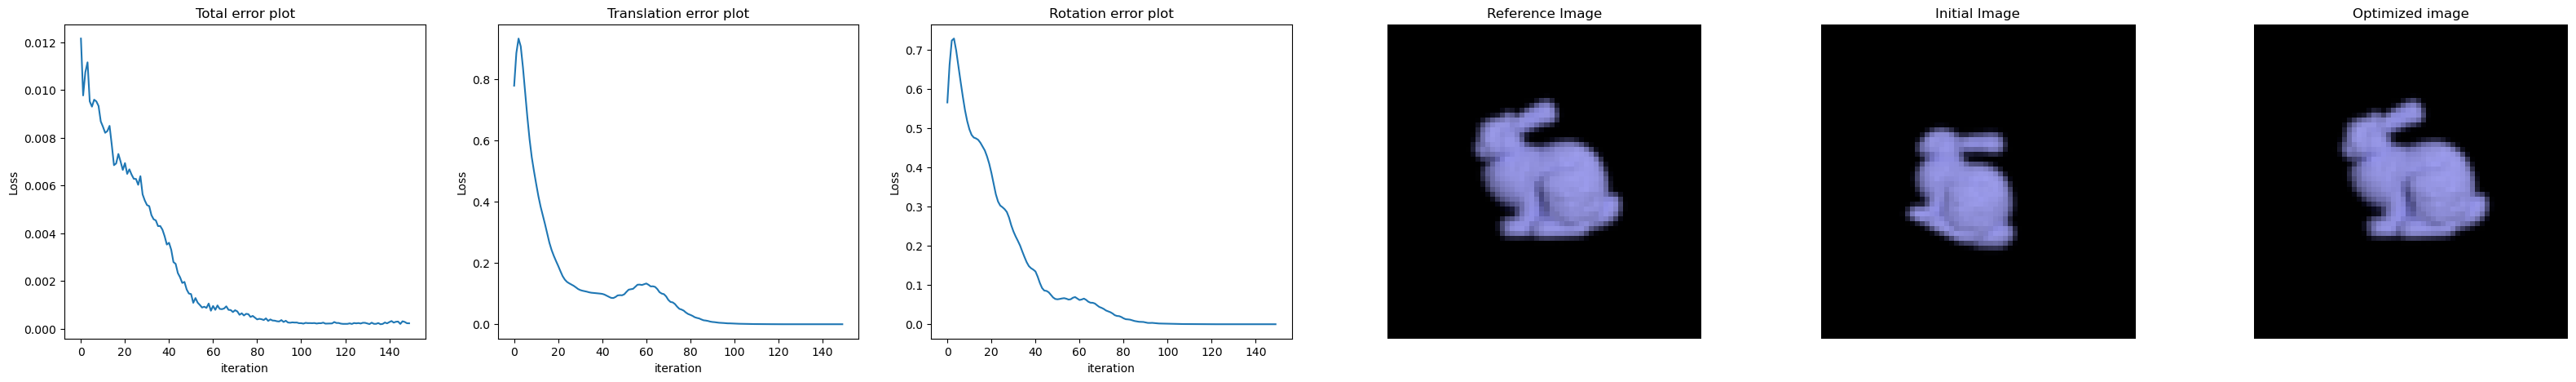

In [22]:
f = "se0"
record_p_1, record_r_1 = run_optimization(f, params,scene,opt,img_ref,iteration_count=its,spp=64)

In [23]:
vis_result(f,record_p_1,record_r_1,ref_R,ref_T,coef=0.05,reduce_scale=10)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0163668…

Plot saved to file ./camera_results/se0bunny.html.


## e2

In [24]:
scene, params, img_ref = init_scene()

In [25]:
opt = R_Adam(lr=0.05,mode = 1)
wu = SE3_to_se3(opt_init_state.matrix)
opt['w'] = mi.Point3f(wu[0],wu[1],wu[2])
opt['u'] = mi.Point3f(wu[3],wu[4],wu[5])

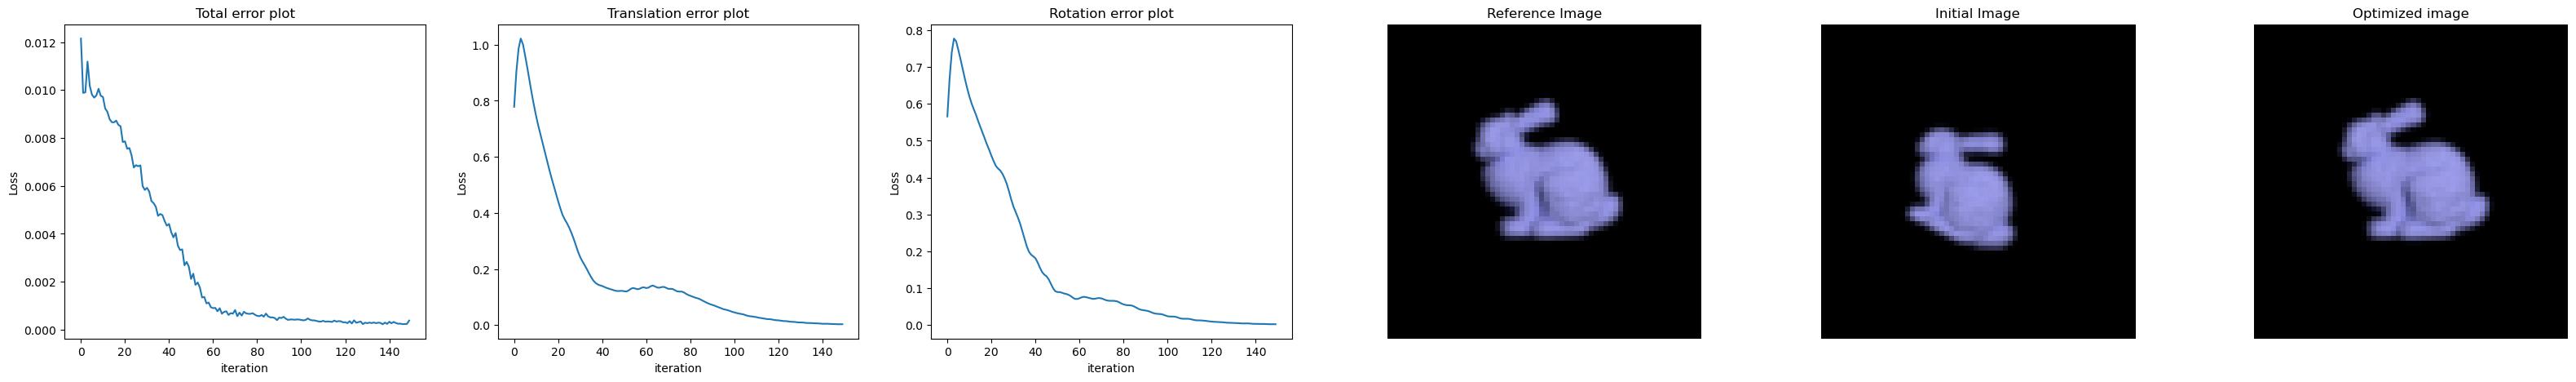

In [26]:
f = "se1"
record_p_1, record_r_1 = run_optimization(f, params,scene,opt,img_ref,iteration_count=its,spp=64)

In [27]:
vis_result(f,record_p_1,record_r_1,ref_R,ref_T,coef=0.05,reduce_scale=10)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0163668…

Plot saved to file ./camera_results/se1bunny.html.


## e3

In [28]:
scene, params, img_ref = init_scene()

In [29]:
opt = R_Adam(lr=0.05,mode = 2)
wu = SE3_to_se3(opt_init_state.matrix)
opt['w'] = mi.Point3f(wu[0],wu[1],wu[2])
opt['u'] = mi.Point3f(wu[3],wu[4],wu[5])

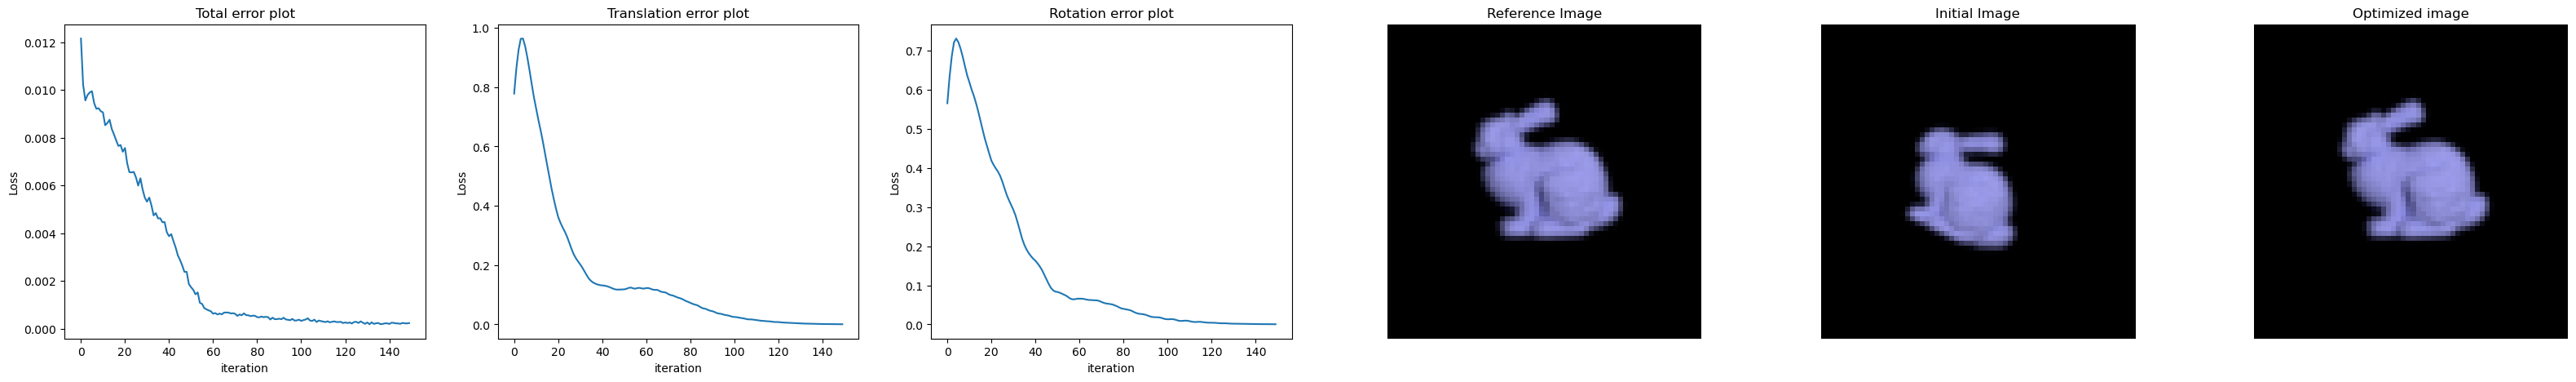

In [30]:
f = "se2"
record_p_1, record_r_1 = run_optimization(f, params,scene,opt,img_ref,iteration_count=its,spp=64)

In [31]:
vis_result(f,record_p_1,record_r_1,ref_R,ref_T,coef=0.05,reduce_scale=10)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0163668…

Plot saved to file ./camera_results/se2bunny.html.


# Euler

## Utils

TODO: need to modify the euler angle!!!

In [126]:
def apply_transformation(params, opt):

    trafo = mi.Transform4f.translate(opt['T']).rotate([0, 0, 1], opt['Rotation'].z ).rotate([0, 1, 0], opt['Rotation'].y ).rotate([1, 0, 0], opt['Rotation'].x )
    
    params['sensor.to_world'] = trafo
    params.update()

In [127]:
def run_optimization(f,params, scene, opt, img_ref, iteration_count = 100, spp = 64):

    with dr.suspend_grad():
        apply_transformation(params, opt)
        img_init = mi.render(scene, seed=0, spp=1024)
    mi.util.convert_to_bitmap(img_init)
    loss_hist = []
    lt = []
    lr = []
    record_p = []
    record_r = []

    for it in range(iteration_count):

        # Apply the mesh transformation 
        with dr.suspend_grad():
            record_r.append(mi.Matrix3f(params['sensor.to_world'].matrix))
            record_p.append([opt['T'].x[0],opt['T'].y[0],opt['T'].z[0]])

        apply_transformation(params, opt)


        with dr.suspend_grad():
            lt.append(dr.sum(dr.sqr(params['sensor.to_world'].translation() - initial_to_world.translation())))
            lr.append(dr.sum(dr.sum(dr.unravel(mi.Matrix3f, dr.sqr(dr.ravel(mi.Matrix3f(params['sensor.to_world'].matrix - initial_to_world.matrix)))))))
        
        # Perform a differentiable rendering
        img = mi.render(scene, params, seed=it, spp=spp)

        # Evaluate the objective function
        loss = dr.sum(dr.sqr(img - img_ref)) / len(img)

        # Backpropagate through the rendering process
        dr.backward(loss)
        # print(dr.grad(opt['angle']))

        # Optimizer: take a gradient descent step
        opt.step()

        loss_hist.append(loss)
        
        print(f"Iteration {it:02d}: error={loss[0]:6f}", end='\r')

    fig, axs = plt.subplots(1, 6, figsize=(40, 5))

    axs[0].plot(loss_hist)
    axs[0].set_xlabel('iteration'); 
    axs[0].set_ylabel('Loss'); 
    axs[0].set_title('Matrix error plot');

    axs[1].plot(lt)
    axs[1].set_xlabel('iteration'); 
    axs[1].set_ylabel('Loss'); 
    axs[1].set_title('Translation error plot');

    axs[2].plot(lr)
    axs[2].set_xlabel('iteration'); 
    axs[2].set_ylabel('Loss'); 
    axs[2].set_title('Rotation error plot');

    axs[3].imshow(mi.util.convert_to_bitmap(img_ref))
    axs[3].axis('off')
    axs[3].set_title('Reference Image')

    axs[4].imshow(mi.util.convert_to_bitmap(img_init))
    axs[4].axis('off')
    axs[4].set_title('Initial Image')

    axs[5].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=1024)))
    axs[5].axis('off')
    axs[5].set_title('Optimized image')

    np.save('./camera_results/'+f+'_loss.npy',loss_hist)
    np.save('./camera_results/'+f+'_trans_loss.npy',lt)
    np.save('./camera_results/'+f+'_rot_loss.npy',lr)
    plt.savefig('./camera_results/'+f+'.png')
    # plt.savefig('./matrix/loss'+file+'.png')
    return record_p, record_r

## e1

In [34]:
scene, params, img_ref = init_scene()

In [128]:
opt = R_Adam(lr=0.05, mode=0)
euler = dr.quat_to_euler(dr.matrix_to_quat(mi.Matrix3f(opt_init_state.matrix)))
opt['Rotation'] = mi.Vector3f(np.rad2deg(euler.x),np.rad2deg(euler.y),np.rad2deg(euler.z))
opt['T'] = opt_init_state.translation()

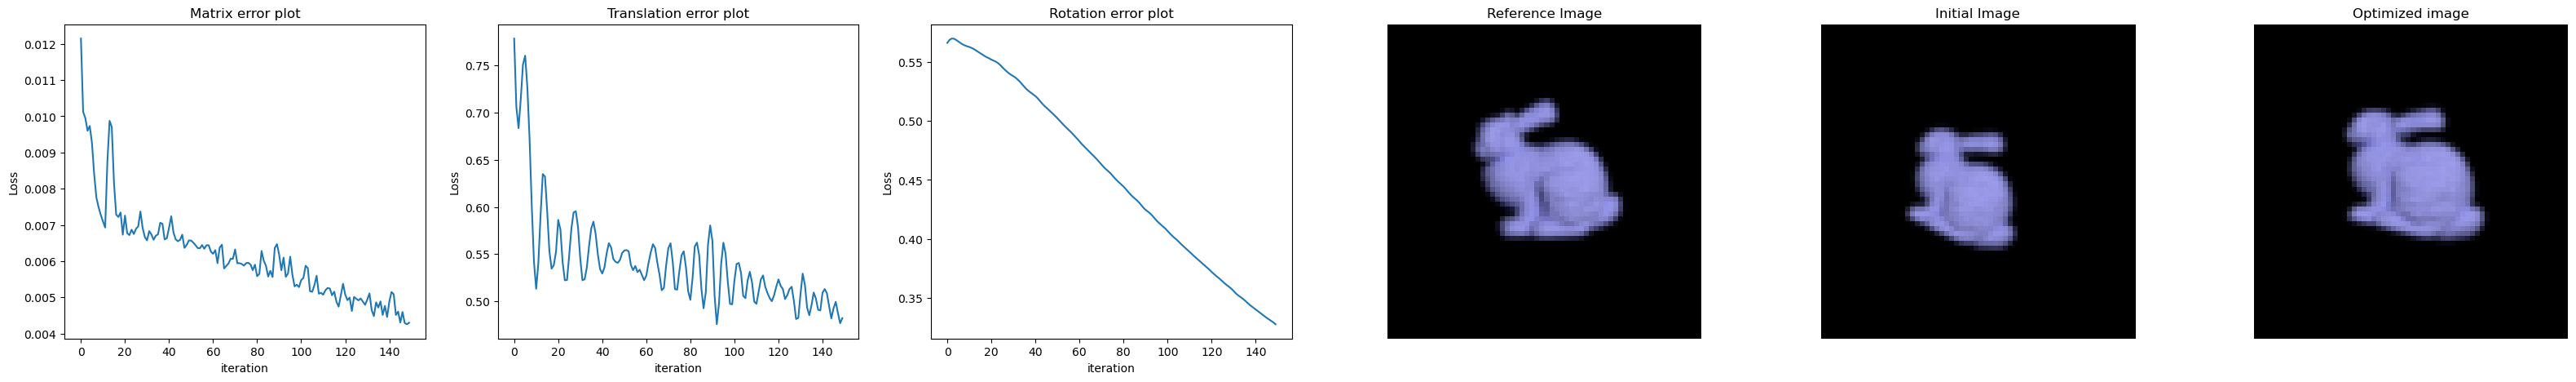

In [129]:
f = "euler0"
record_p_e_1, record_r_e_1 = run_optimization(f,params,scene,opt,img_ref,iteration_count=its,spp=64)

In [37]:
vis_result(f,record_p_e_1,record_r_e_1,ref_R,ref_T,coef=0.05,reduce_scale=10)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0163668…

Plot saved to file ./camera_results/euler0bunny.html.


## e2

In [38]:
scene, params, img_ref = init_scene()

In [39]:
opt = R_Adam(lr=0.05, mode=1)
euler = dr.quat_to_euler(dr.matrix_to_quat(mi.Matrix3f(opt_init_state.matrix)))
opt['Rotation'] = mi.Vector3f(np.rad2deg(euler.x),np.rad2deg(euler.y),np.rad2deg(euler.z))
opt['T'] = opt_init_state.translation()

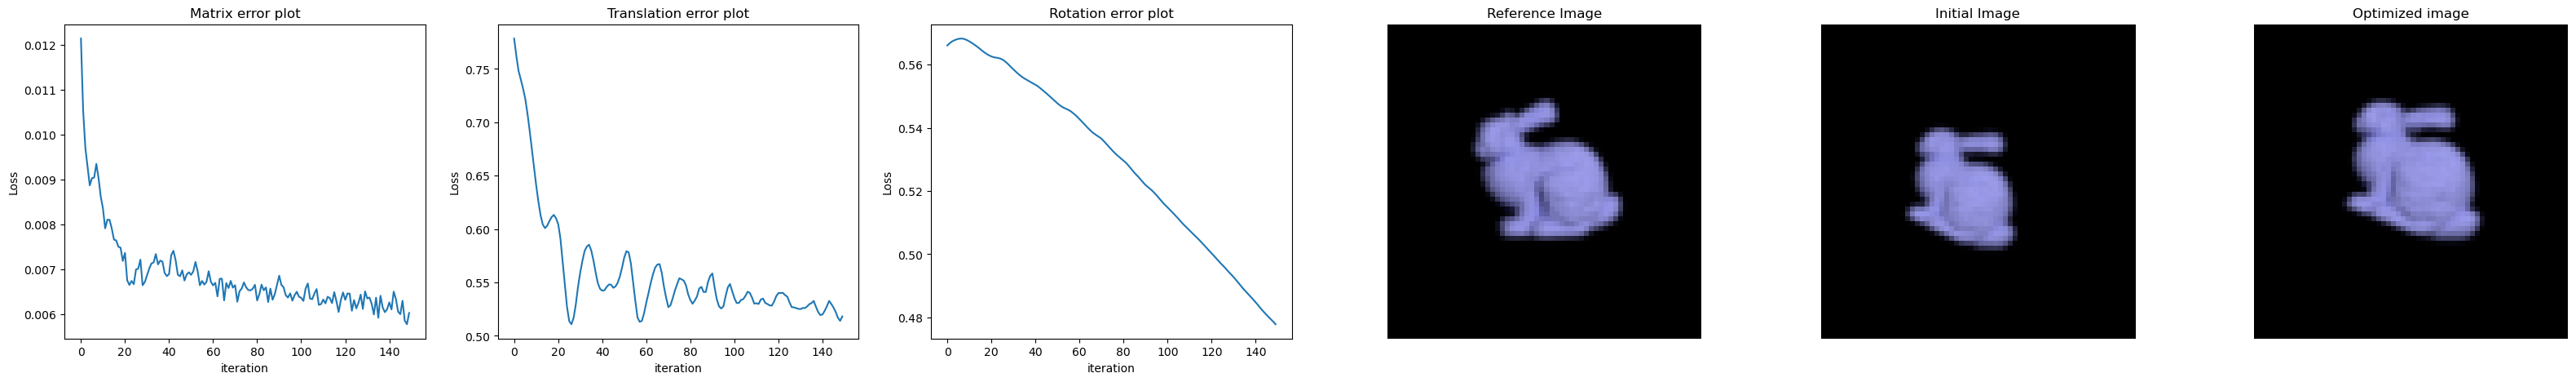

In [40]:
f = "euler1"
record_p_e_1, record_r_e_1 = run_optimization(f,params,scene,opt,img_ref,iteration_count=its,spp=64)

In [41]:
vis_result(f,record_p_e_1,record_r_e_1,ref_R,ref_T,coef=0.05,reduce_scale=10)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0163668…

Plot saved to file ./camera_results/euler1bunny.html.


## e3

In [42]:
scene, params, img_ref = init_scene()

In [43]:
opt = R_Adam(lr=0.05, mode=2)
euler = dr.quat_to_euler(dr.matrix_to_quat(mi.Matrix3f(opt_init_state.matrix)))
opt['Rotation'] = mi.Vector3f(np.rad2deg(euler.x),np.rad2deg(euler.y),np.rad2deg(euler.z))
opt['T'] = opt_init_state.translation()

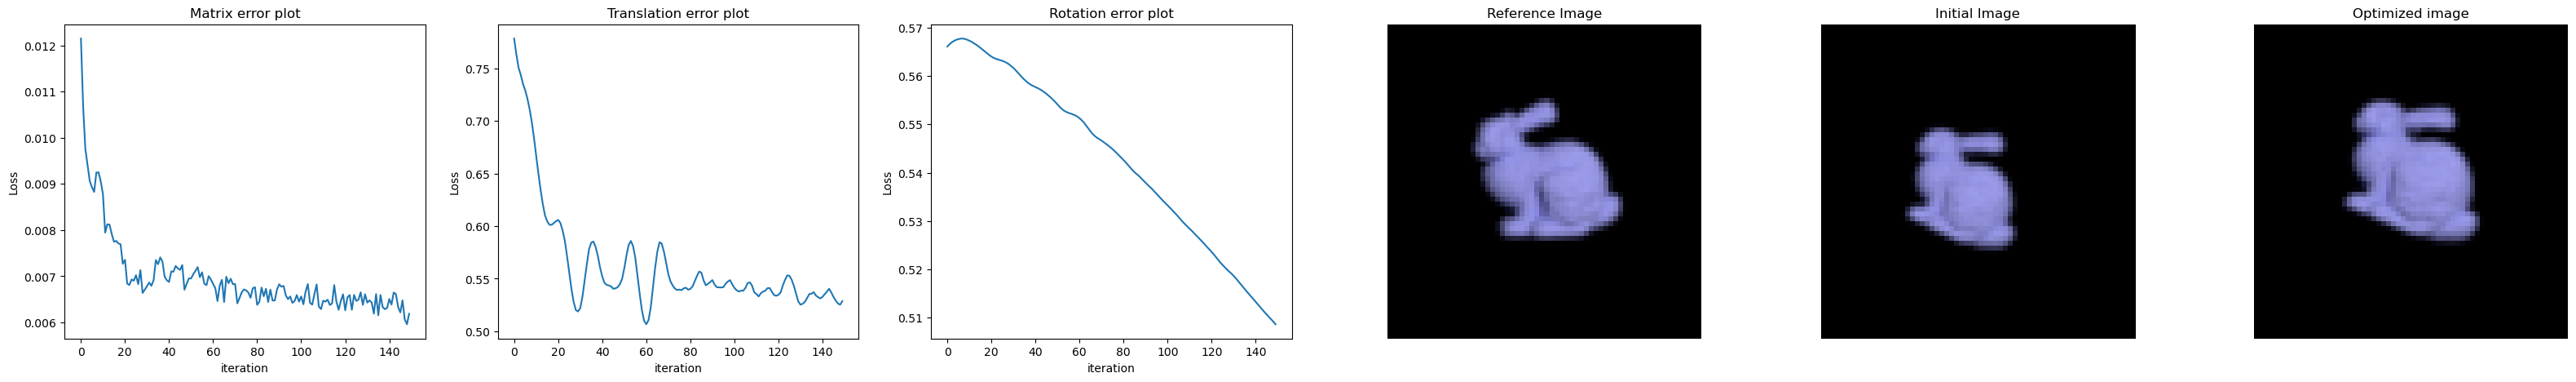

In [44]:
f = "euler2"
record_p_e_1, record_r_e_1 = run_optimization(f,params,scene,opt,img_ref,iteration_count=its,spp=64)

In [45]:
vis_result(f,record_p_e_1,record_r_e_1,ref_R,ref_T,coef=0.05,reduce_scale=10)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0163668…

Plot saved to file ./camera_results/euler2bunny.html.


# Vector

## Utils

In [46]:
type(mi.Transform4f.translate(opt['T']) @ mi.Matrix4f(so3_to_SO3(w_to_wx(opt['Rotation']))))

mitsuba.cuda_ad_rgb.Transform4f

In [47]:
def apply_transformation(params, opt):

    trafo = mi.Transform4f.translate(opt['T']) @ mi.Matrix4f(so3_to_SO3(w_to_wx(opt['Rotation'])))

    params['sensor.to_world'] = trafo
    params.update()

In [49]:
def run_optimization(f,params, scene, opt, img_ref, iteration_count = 100, spp = 64):

    with dr.suspend_grad():
        apply_transformation(params, opt)
        img_init = mi.render(scene, seed=0, spp=1024)
    mi.util.convert_to_bitmap(img_init)
    loss_hist = []
    lt = []
    lr = []
    record_p = []
    record_r = []

    for it in range(iteration_count):

        # Apply the mesh transformation 
        with dr.suspend_grad():
            record_r.append(so3_to_SO3(w_to_wx(opt['Rotation'])))
            record_p.append([opt['T'].x[0],opt['T'].y[0],opt['T'].z[0]])

        apply_transformation(params, opt)

        with dr.suspend_grad():
            lt.append(dr.sum(dr.sqr(params['sensor.to_world'].translation() - initial_to_world.translation())))
            lr.append(dr.sum(dr.sum(dr.unravel(mi.Matrix3f, dr.sqr(dr.ravel(mi.Matrix3f(params['sensor.to_world'].matrix - initial_to_world.matrix)))))))
        
        # Perform a differentiable rendering
        img = mi.render(scene, params, seed=it, spp=spp)

        # Evaluate the objective function
        loss = dr.sum(dr.sqr(img - img_ref)) / len(img)

        # Backpropagate through the rendering process
        dr.backward(loss)
        # print(dr.grad(opt['angle']))

        # Optimizer: take a gradient descent step
        opt.step()

        loss_hist.append(loss)
        
        print(f"Iteration {it:02d}: error={loss[0]:6f}", end='\r')

    fig, axs = plt.subplots(1, 6, figsize=(40, 5))

    axs[0].plot(loss_hist)
    axs[0].set_xlabel('iteration'); 
    axs[0].set_ylabel('Loss'); 
    axs[0].set_title('Matrix error plot');

    axs[1].plot(lt)
    axs[1].set_xlabel('iteration'); 
    axs[1].set_ylabel('Loss'); 
    axs[1].set_title('Translation error plot');

    axs[2].plot(lr)
    axs[2].set_xlabel('iteration'); 
    axs[2].set_ylabel('Loss'); 
    axs[2].set_title('Rotation error plot');

    axs[3].imshow(mi.util.convert_to_bitmap(img_ref))
    axs[3].axis('off')
    axs[3].set_title('Reference Image')

    axs[4].imshow(mi.util.convert_to_bitmap(img_init))
    axs[4].axis('off')
    axs[4].set_title('Initial Image')

    axs[5].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=1024)))
    axs[5].axis('off')
    axs[5].set_title('Optimized image')
    np.save('./camera_results/'+f+'_loss.npy',loss_hist)
    np.save('./camera_results/'+f+'_trans_loss.npy',lt)
    np.save('./camera_results/'+f+'_rot_loss.npy',lr)
    plt.savefig('./camera_results/'+f+'.png')
    # plt.savefig('./matrix/loss'+file+'.png')
    return record_p, record_r

## e1

In [50]:
scene, params, img_ref = init_scene()

In [51]:
opt = R_Adam(lr=0.05, mode=0)
opt['Rotation'] = SO3_to_so3(mi.Matrix3f(opt_init_state.matrix))
opt['T'] = opt_init_state.translation()

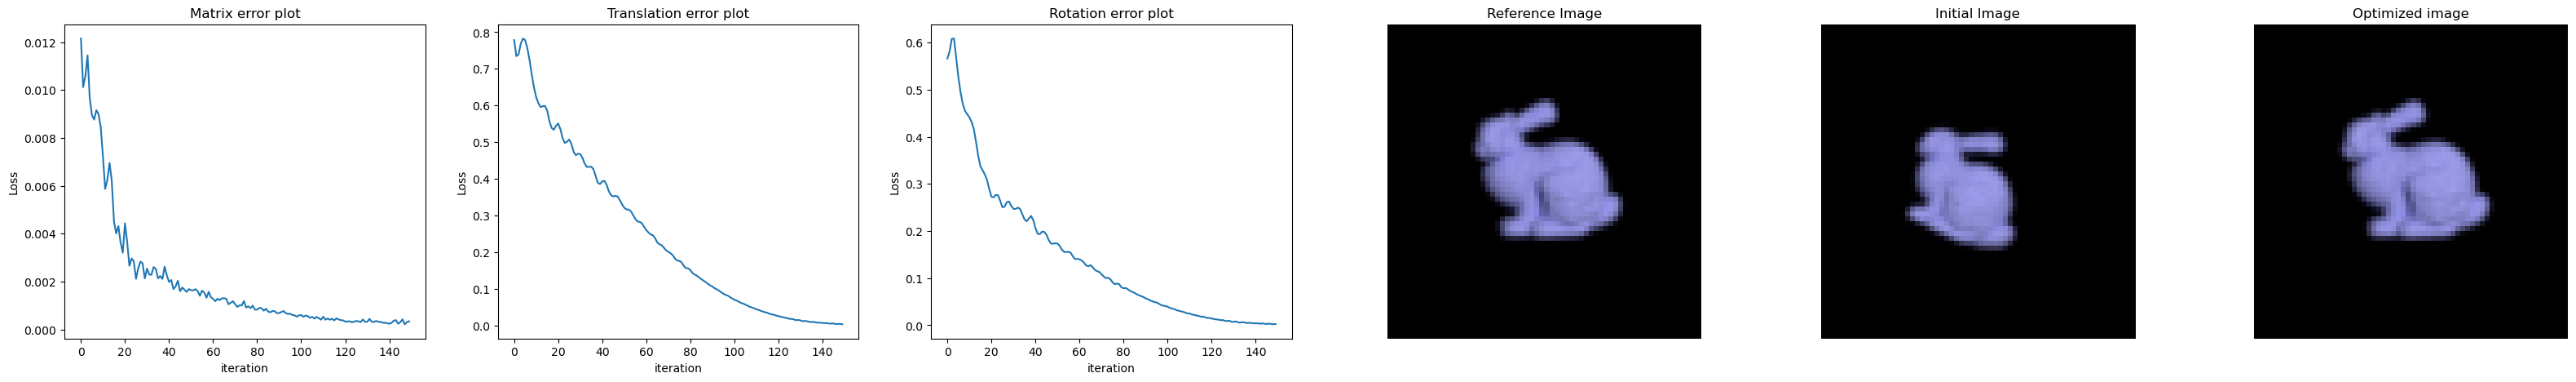

In [52]:
f = "vector0"
record_p_1, record_r_1 = run_optimization(f, params,scene,opt,img_ref,iteration_count=its,spp=64)

In [53]:
vis_result(f,record_p_1,record_r_1,ref_R,ref_T,coef=0.05,reduce_scale=10)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0163668…

Plot saved to file ./camera_results/vector0bunny.html.


## e2

In [54]:
scene, params, img_ref = init_scene()

In [55]:
opt = R_Adam(lr=0.05, mode=1)
opt['Rotation'] = SO3_to_so3(mi.Matrix3f(opt_init_state.matrix))
opt['T'] = opt_init_state.translation()

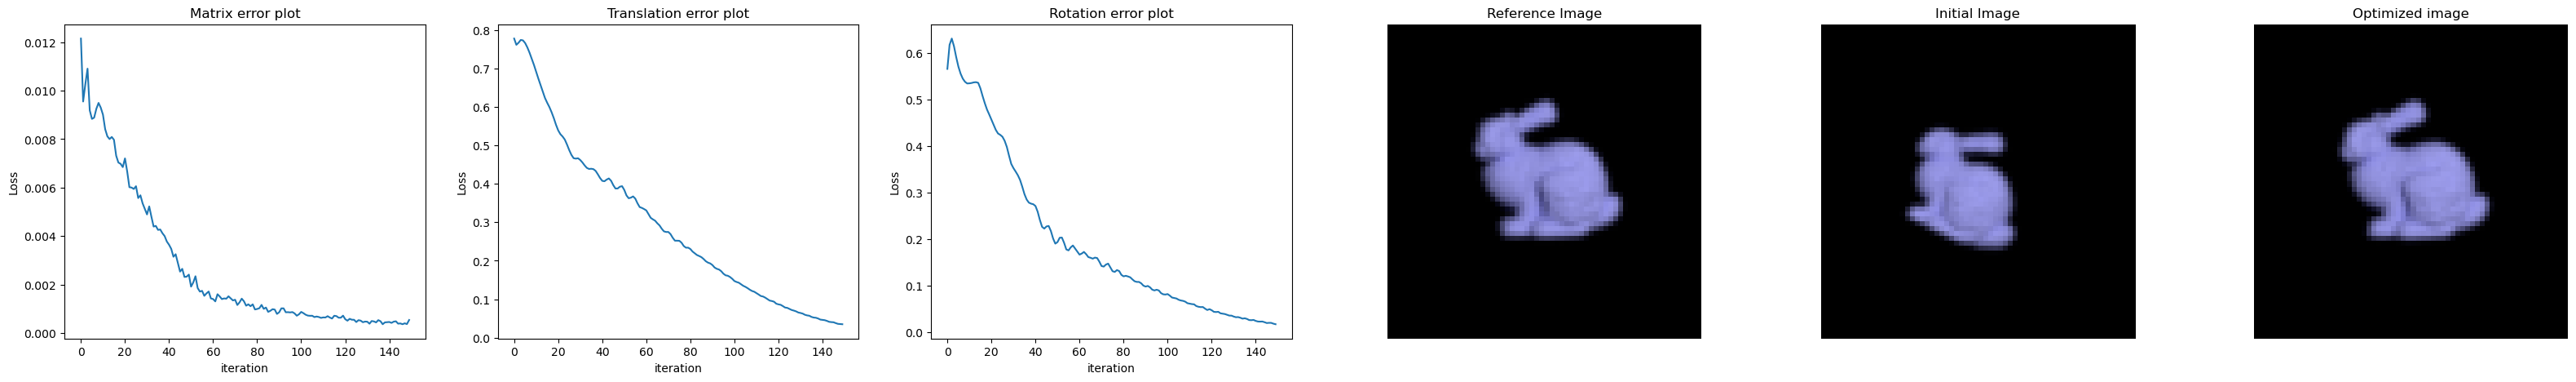

In [56]:
f = "vector1"
record_p_1, record_r_1 = run_optimization(f, params,scene,opt,img_ref,iteration_count=its,spp=64)

In [57]:
vis_result(f,record_p_1,record_r_1,ref_R,ref_T,coef=0.05,reduce_scale=10)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0163668…

Plot saved to file ./camera_results/vector1bunny.html.


## e3

In [58]:
scene, params, img_ref = init_scene()

In [59]:
opt = R_Adam(lr=0.05, mode=2)
opt['Rotation'] = SO3_to_so3(mi.Matrix3f(opt_init_state.matrix))
opt['T'] = opt_init_state.translation()

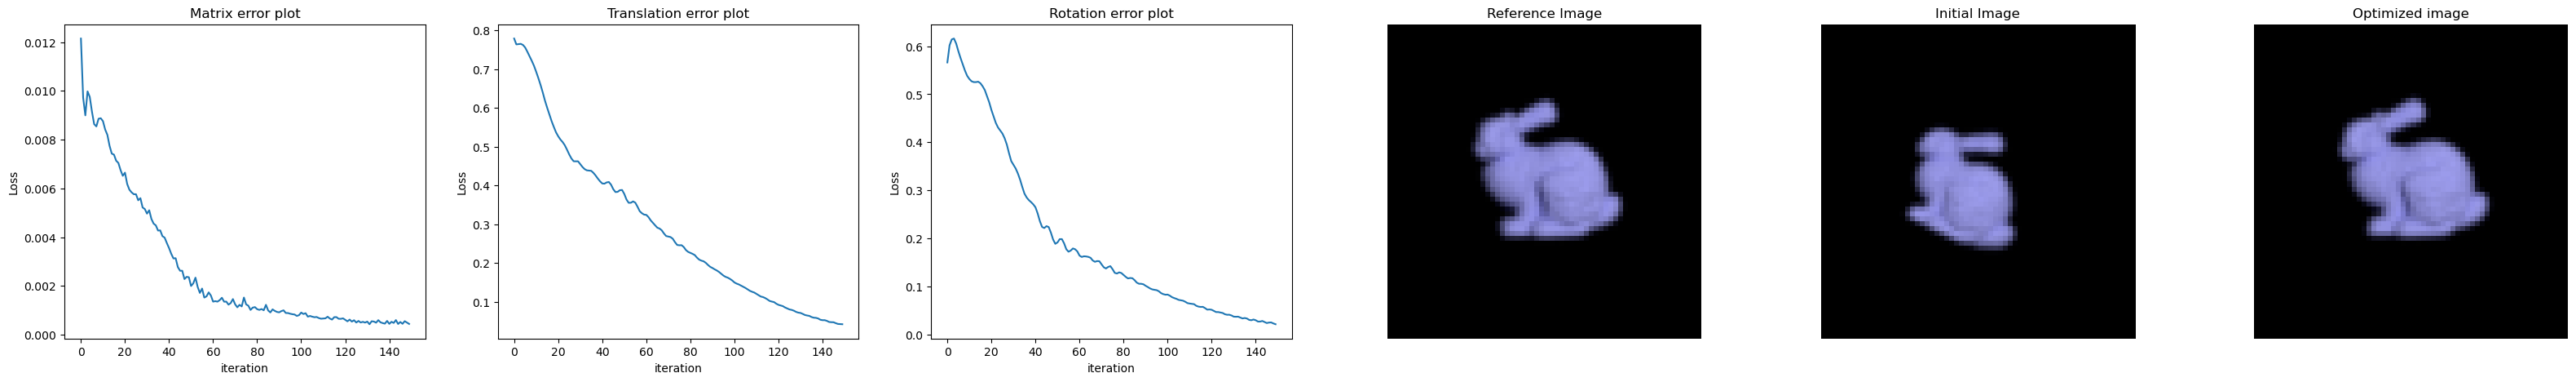

In [60]:
f = "vector2"
record_p_1, record_r_1 = run_optimization(f, params,scene,opt,img_ref,iteration_count=its,spp=64)

In [61]:
vis_result(f,record_p_1,record_r_1,ref_R,ref_T,coef=0.05,reduce_scale=10)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0163668…

Plot saved to file ./camera_results/vector2bunny.html.


# SO(3)

## Utils

In [62]:
def apply_transformation(params, opt):

    trafo = mi.Transform4f.translate(opt['Trans']) @ mi.Matrix4f(opt['R'])
    
    params['sensor.to_world'] = trafo
    params.update()

In [63]:
def run_optimization(f,params, scene, opt, img_ref, iteration_count = 100, spp = 64):

    with dr.suspend_grad():
        apply_transformation(params, opt)
        img_init = mi.render(scene, seed=0, spp=1024)
    mi.util.convert_to_bitmap(img_init)
    loss_hist = []
    lt = []
    lr = []
    record_p = []
    record_r = []

    for it in range(iteration_count):

        # Apply the mesh transformation 
        with dr.suspend_grad():
            record_r.append(opt['R'])
            record_p.append([opt['Trans'].x[0],opt['Trans'].y[0],opt['Trans'].z[0]])
            
        apply_transformation(params, opt)

        with dr.suspend_grad():
            lt.append(dr.sum(dr.sqr(params['sensor.to_world'].translation() - initial_to_world.translation())))
            lr.append(dr.sum(dr.sum(dr.unravel(mi.Matrix3f, dr.sqr(dr.ravel(mi.Matrix3f(params['sensor.to_world'].matrix - initial_to_world.matrix)))))))
        
        # Perform a differentiable rendering
        img = mi.render(scene, params, seed=it, spp=spp)

        # Evaluate the objective function
        loss = dr.sum(dr.sqr(img - img_ref)) / len(img)

        # Backpropagate through the rendering process
        dr.backward(loss)
        # print(dr.grad(opt['angle']))

        # Optimizer: take a gradient descent step
        opt.step()

        loss_hist.append(loss)
        
        print(f"Iteration {it:02d}: error={loss[0]:6f}", end='\r')

    fig, axs = plt.subplots(1, 6, figsize=(40, 5))

    axs[0].plot(loss_hist)
    axs[0].set_xlabel('iteration'); 
    axs[0].set_ylabel('Loss'); 
    axs[0].set_title('Total error plot');


    axs[1].plot(lt)
    axs[1].set_xlabel('iteration'); 
    axs[1].set_ylabel('Loss'); 
    axs[1].set_title('Translation error plot');


    axs[2].plot(lr)
    axs[2].set_xlabel('iteration'); 
    axs[2].set_ylabel('Loss'); 
    axs[2].set_title('Rotation error plot');


    axs[3].imshow(mi.util.convert_to_bitmap(img_ref))
    axs[3].axis('off')
    axs[3].set_title('Reference Image')

    axs[4].imshow(mi.util.convert_to_bitmap(img_init))
    axs[4].axis('off')
    axs[4].set_title('Initial Image')

    axs[5].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=1024)))
    axs[5].axis('off')
    axs[5].set_title('Optimized image')

    np.save('./camera_results/'+f+'_loss.npy',loss_hist)
    np.save('./camera_results/'+f+'_trans_loss.npy',lt)
    np.save('./camera_results/'+f+'_rot_loss.npy',lr)
    plt.savefig('./camera_results/'+f+'.png')
    return record_p, record_r

## e1

In [64]:
scene, params, img_ref = init_scene()

In [65]:
opt = R_Adam(lr=0.05, mode=0)
opt['R'] = mi.Matrix3f(opt_init_state.matrix)
opt['Trans'] = opt_init_state.translation()

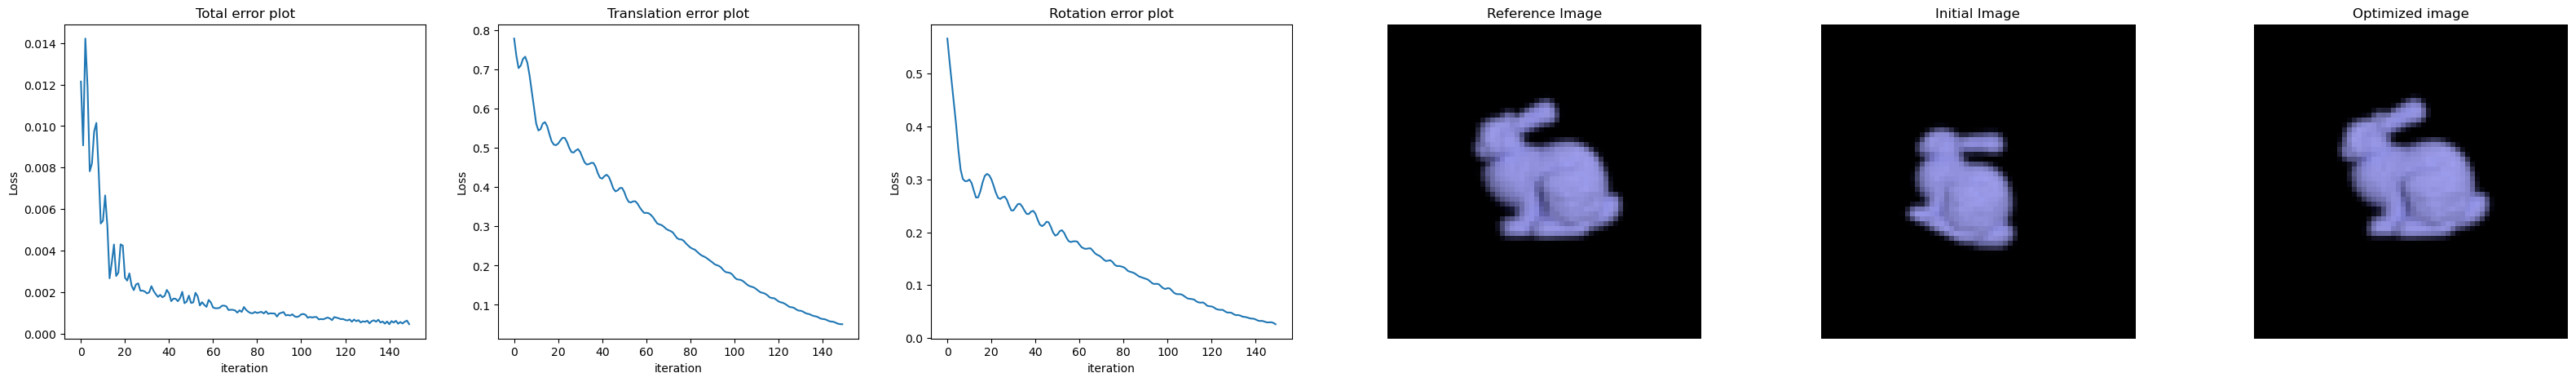

In [66]:
f = "so0"
record_p_1, record_r_1 = run_optimization(f, params,scene,opt,img_ref,iteration_count=its,spp=64)

In [67]:
vis_result(f,record_p_1,record_r_1,ref_R,ref_T,coef=0.05,reduce_scale=10)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0163668…

Plot saved to file ./camera_results/so0bunny.html.


## e2

In [68]:
scene, params, img_ref = init_scene()

In [69]:
opt = R_Adam(lr=0.05, mode=1)
opt['R'] = mi.Matrix3f(opt_init_state.matrix)
opt['Trans'] = opt_init_state.translation()

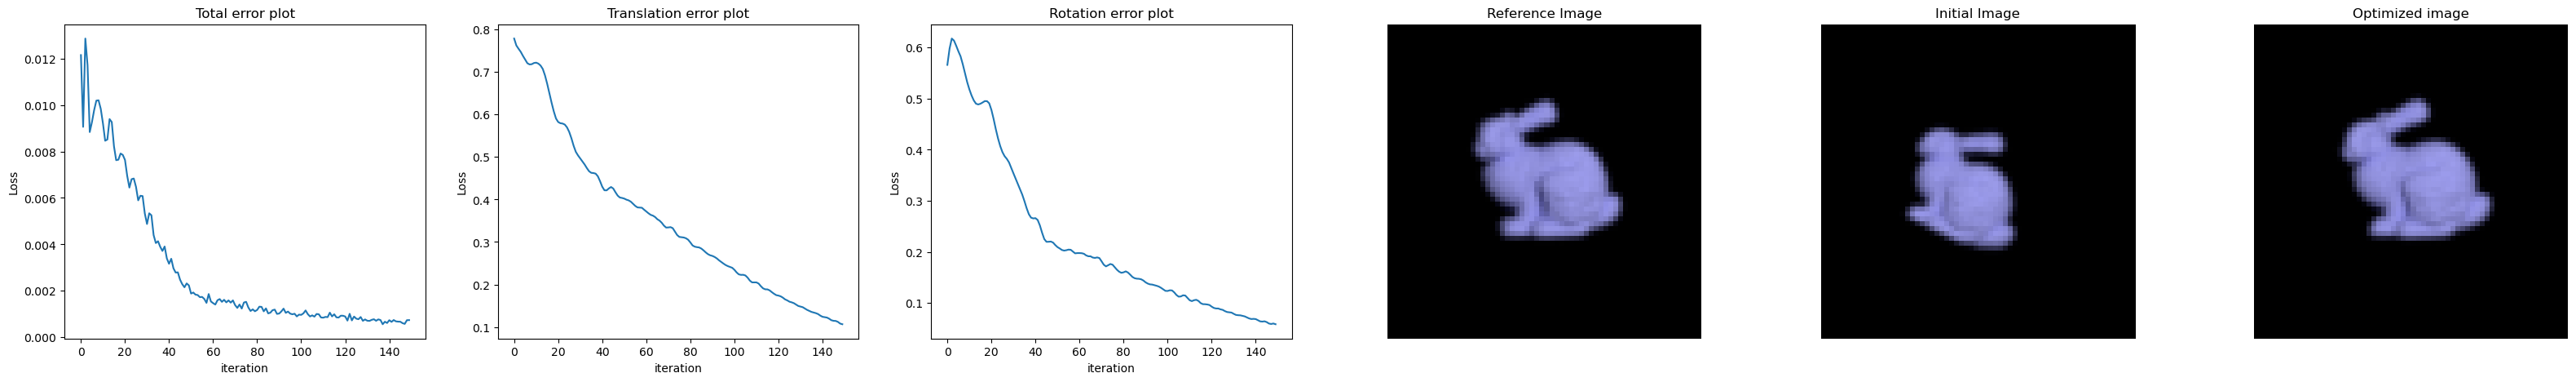

In [70]:
f = "so1"
record_p_1, record_r_1 = run_optimization(f, params,scene,opt,img_ref,iteration_count=its,spp=64)

In [71]:
vis_result(f,record_p_1,record_r_1,ref_R,ref_T,coef=0.05,reduce_scale=10)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0163668…

Plot saved to file ./camera_results/so1bunny.html.


## e3

In [72]:
scene, params, img_ref = init_scene()

In [73]:
opt = R_Adam(lr=0.05, mode=2)
opt['R'] = mi.Matrix3f(opt_init_state.matrix)
opt['Trans'] = opt_init_state.translation()

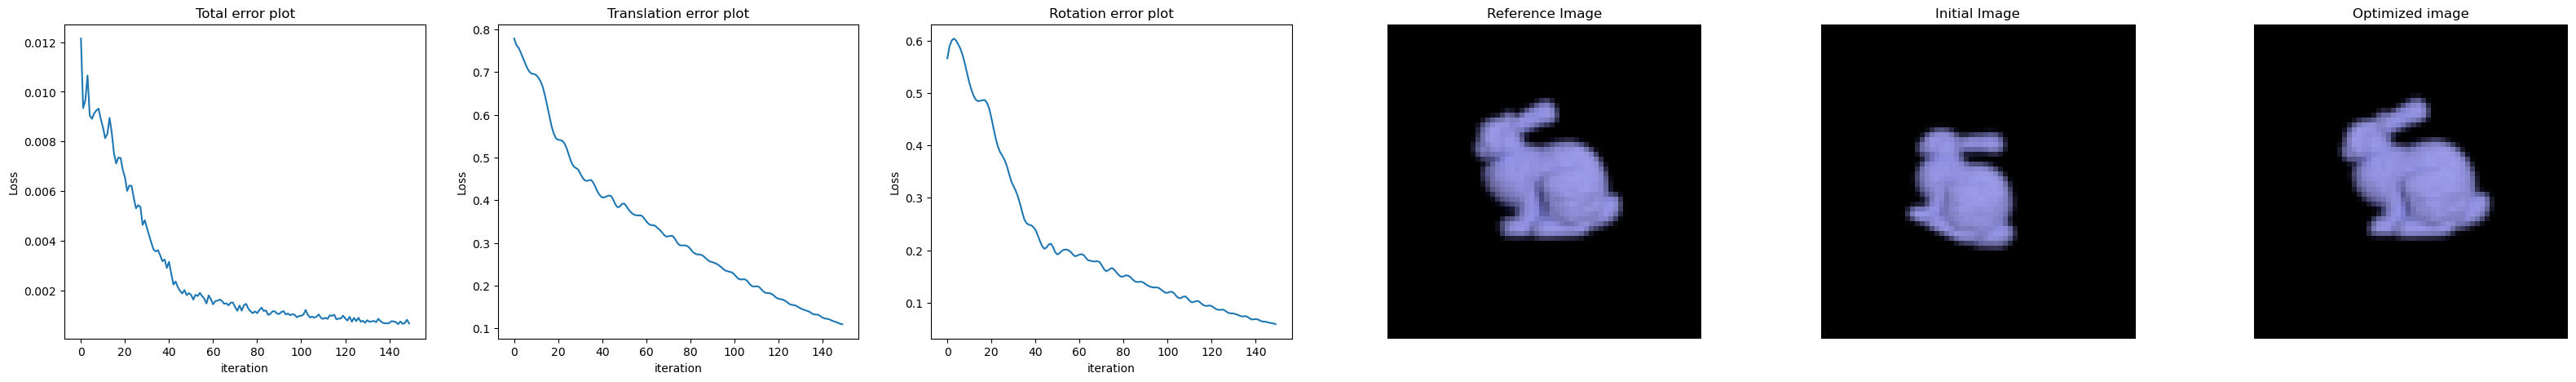

In [74]:
f = "so2"
record_p_1, record_r_1 = run_optimization(f, params,scene,opt,img_ref,iteration_count=its,spp=64)

In [75]:
vis_result(f,record_p_1,record_r_1,ref_R,ref_T,coef=0.05,reduce_scale=10)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0163668…

Plot saved to file ./camera_results/so2bunny.html.


# Q1

## Utils

In [76]:
def apply_transformation(params, opt):

    trafo = mi.Transform4f.translate(opt['Trans']) @ dr.quat_to_matrix(mi.Quaternion4f(opt['q']))
    
    params['sensor.to_world'] = trafo
    params.update()

In [77]:
def run_optimization(f,params, scene, opt, img_ref, iteration_count = 100, spp = 64):

    with dr.suspend_grad():
        apply_transformation(params, opt)
        img_init = mi.render(scene, seed=0, spp=1024)
    mi.util.convert_to_bitmap(img_init)
    loss_hist = []
    lt = []
    lr = []
    record_p = []
    record_r = []

    for it in range(iteration_count):

        # Apply the mesh transformation 
        with dr.suspend_grad():
            record_r.append(mi.Matrix3f(dr.quat_to_matrix(mi.Quaternion4f(opt['q']))))
            record_p.append([opt['Trans'].x[0],opt['Trans'].y[0],opt['Trans'].z[0]])
        
        opt['q']  = dr.normalize(opt['q'])
        apply_transformation(params, opt)

        with dr.suspend_grad():
            lt.append(dr.sum(dr.sqr(params['sensor.to_world'].translation() - initial_to_world.translation())))
            lr.append(dr.sum(dr.sum(dr.unravel(mi.Matrix3f, dr.sqr(dr.ravel(mi.Matrix3f(params['sensor.to_world'].matrix - initial_to_world.matrix)))))))
        
        # Perform a differentiable rendering
        img = mi.render(scene, params, seed=it, spp=spp)

        # Evaluate the objective function
        loss = dr.sum(dr.sqr(img - img_ref)) / len(img)

        # Backpropagate through the rendering process
        dr.backward(loss)
        # print(dr.grad(opt['angle']))

        # Optimizer: take a gradient descent step
        opt.step()

        loss_hist.append(loss)
        
        print(f"Iteration {it:02d}: error={loss[0]:6f}", end='\r')

    fig, axs = plt.subplots(1, 6, figsize=(40, 5))

    axs[0].plot(loss_hist)
    axs[0].set_xlabel('iteration'); 
    axs[0].set_ylabel('Loss'); 
    axs[0].set_title('Total error plot');


    axs[1].plot(lt)
    axs[1].set_xlabel('iteration'); 
    axs[1].set_ylabel('Loss'); 
    axs[1].set_title('Translation error plot');


    axs[2].plot(lr)
    axs[2].set_xlabel('iteration'); 
    axs[2].set_ylabel('Loss'); 
    axs[2].set_title('Rotation error plot');


    axs[3].imshow(mi.util.convert_to_bitmap(img_ref))
    axs[3].axis('off')
    axs[3].set_title('Reference Image')

    axs[4].imshow(mi.util.convert_to_bitmap(img_init))
    axs[4].axis('off')
    axs[4].set_title('Initial Image')

    axs[5].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=1024)))
    axs[5].axis('off')
    axs[5].set_title('Optimized image')

    np.save('./camera_results/'+f+'_loss.npy',loss_hist)
    np.save('./camera_results/'+f+'_trans_loss.npy',lt)
    np.save('./camera_results/'+f+'_rot_loss.npy',lr)
    plt.savefig('./camera_results/'+f+'.png')
    return record_p, record_r

## e1

In [78]:
scene, params, img_ref = init_scene()

In [79]:
opt = R_Adam(lr=0.05,mode = 0)
# opt['q'] = w_to_q(SO3_to_so3(mi.Matrix3f(opt_init_state.matrix)))
opt['q'] = mi.Vector4f(dr.matrix_to_quat(mi.Matrix3f(opt_init_state.matrix)))
opt['Trans'] = opt_init_state.translation()

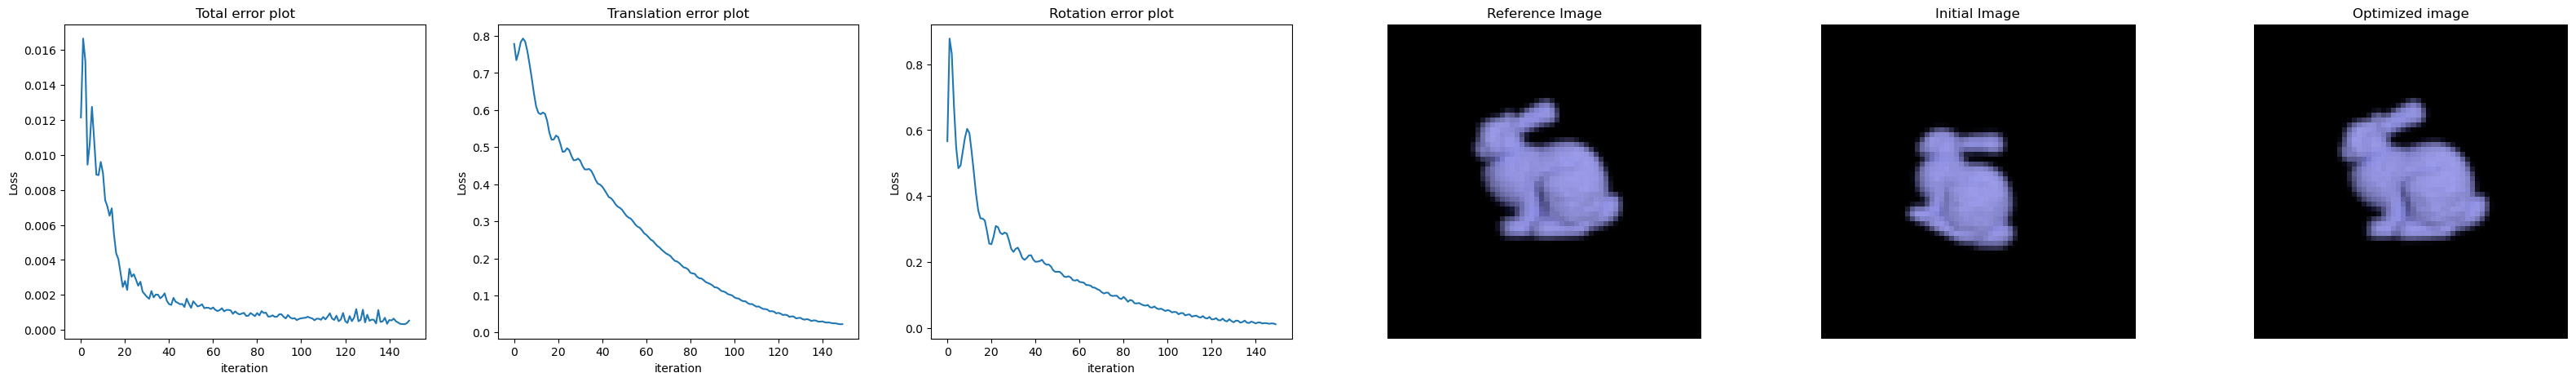

In [80]:
f = "q_v1_0"
record_p_1, record_r_1 = run_optimization(f, params,scene,opt,img_ref,iteration_count=its,spp=64)

In [81]:
vis_result(f,record_p_1,record_r_1,ref_R,ref_T,coef=0.05,reduce_scale=10)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0163668…

Plot saved to file ./camera_results/q_v1_0bunny.html.


## e2

In [82]:
scene, params, img_ref = init_scene()

In [83]:
opt = R_Adam(lr=0.05,mode = 1)
# opt['q'] = w_to_q(SO3_to_so3(mi.Matrix3f(opt_init_state.matrix)))
opt['q'] = mi.Vector4f(dr.matrix_to_quat(mi.Matrix3f(opt_init_state.matrix)))
opt['Trans'] = opt_init_state.translation()

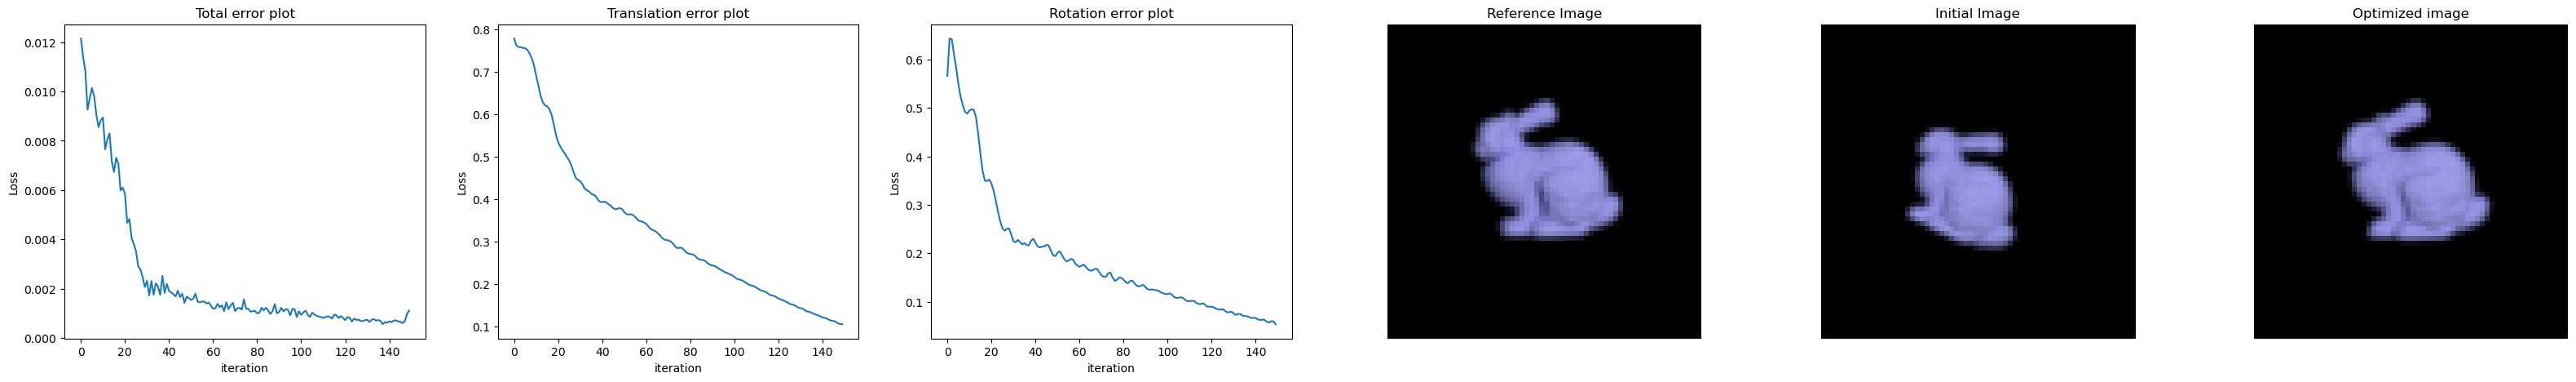

In [84]:
f = "q_v1_1"
record_p_1, record_r_1 = run_optimization(f, params,scene,opt,img_ref,iteration_count=its,spp=64)

In [85]:
vis_result(f,record_p_1,record_r_1,ref_R,ref_T,coef=0.05,reduce_scale=10)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0163668…

Plot saved to file ./camera_results/q_v1_1bunny.html.


## e3

In [86]:
scene, params, img_ref = init_scene()

In [87]:
opt = R_Adam(lr=0.05,mode = 2)
# opt['q'] = w_to_q(SO3_to_so3(mi.Matrix3f(opt_init_state.matrix)))
opt['q'] = mi.Vector4f(dr.matrix_to_quat(mi.Matrix3f(opt_init_state.matrix)))
opt['Trans'] = opt_init_state.translation()

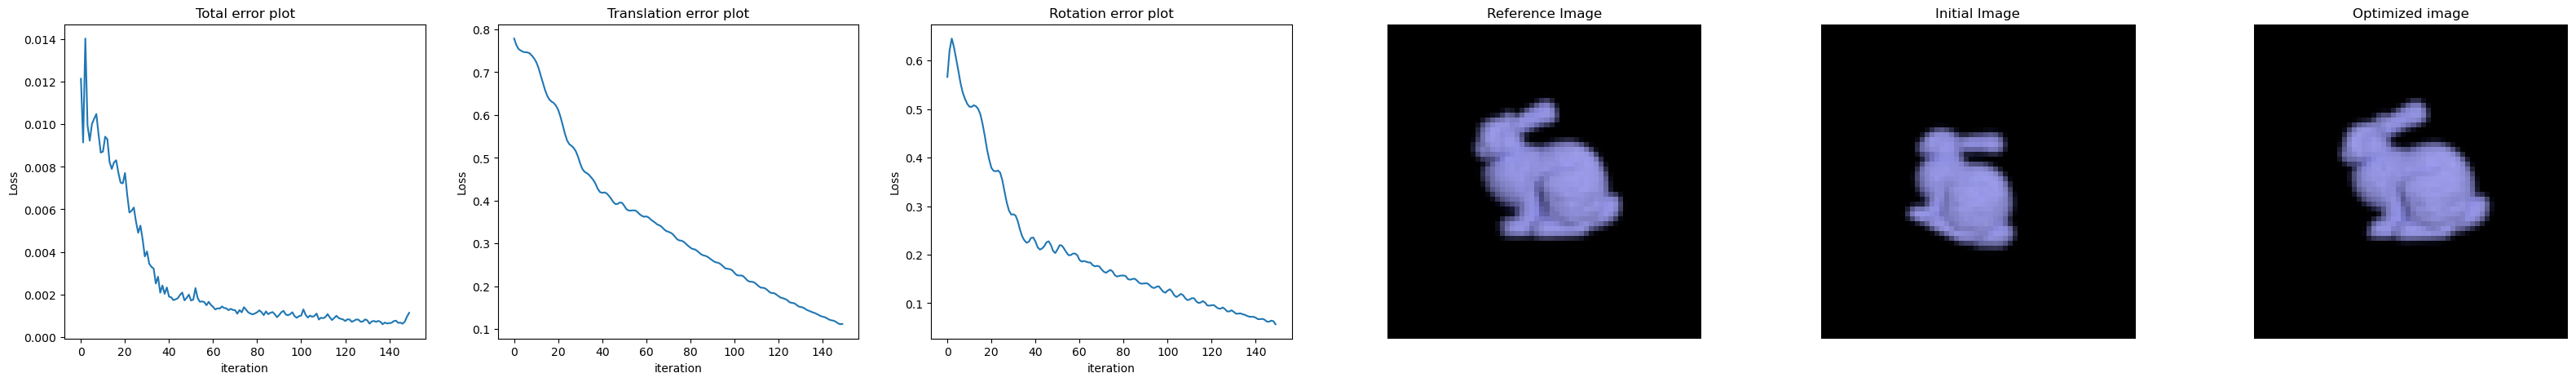

In [88]:
f = "q_v1_2"
record_p_1, record_r_1 = run_optimization(f, params,scene,opt,img_ref,iteration_count=its,spp=64)

In [89]:
vis_result(f,record_p_1,record_r_1,ref_R,ref_T,coef=0.05,reduce_scale=10)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0163668…

Plot saved to file ./camera_results/q_v1_2bunny.html.


# Q2

## Utils

In [90]:
def apply_transformation(params, opt):

    trafo = mi.Transform4f.translate(opt['Trans']) @ dr.quat_to_matrix(mi.Quaternion4f(opt['q']))
    
    params['sensor.to_world'] = trafo
    params.update()

In [91]:
def run_optimization(f,params, scene, opt, img_ref, iteration_count = 100, spp = 64):

    with dr.suspend_grad():
        apply_transformation(params, opt)
        img_init = mi.render(scene, seed=0, spp=1024)
    mi.util.convert_to_bitmap(img_init)
    loss_hist = []
    lt = []
    lr = []
    record_p = []
    record_r = []

    for it in range(iteration_count):

        # Apply the mesh transformation 
        with dr.suspend_grad():
            record_r.append(mi.Matrix3f(dr.quat_to_matrix(mi.Quaternion4f(opt['q']))))
            record_p.append([opt['Trans'].x[0],opt['Trans'].y[0],opt['Trans'].z[0]])
        apply_transformation(params, opt)

        with dr.suspend_grad():
            lt.append(dr.sum(dr.sqr(params['sensor.to_world'].translation() - initial_to_world.translation())))
            lr.append(dr.sum(dr.sum(dr.unravel(mi.Matrix3f, dr.sqr(dr.ravel(mi.Matrix3f(params['sensor.to_world'].matrix - initial_to_world.matrix)))))))
        
        # Perform a differentiable rendering
        img = mi.render(scene, params, seed=it, spp=spp)

        # Evaluate the objective function
        loss = dr.sum(dr.sqr(img - img_ref)) / len(img)

        # Backpropagate through the rendering process
        dr.backward(loss)
        # print(dr.grad(opt['angle']))

        # Optimizer: take a gradient descent step
        opt.step()

        loss_hist.append(loss)
        
        print(f"Iteration {it:02d}: error={loss[0]:6f}", end='\r')

    fig, axs = plt.subplots(1, 6, figsize=(40, 5))

    axs[0].plot(loss_hist)
    axs[0].set_xlabel('iteration'); 
    axs[0].set_ylabel('Loss'); 
    axs[0].set_title('Total error plot');


    axs[1].plot(lt)
    axs[1].set_xlabel('iteration'); 
    axs[1].set_ylabel('Loss'); 
    axs[1].set_title('Translation error plot');


    axs[2].plot(lr)
    axs[2].set_xlabel('iteration'); 
    axs[2].set_ylabel('Loss'); 
    axs[2].set_title('Rotation error plot');


    axs[3].imshow(mi.util.convert_to_bitmap(img_ref))
    axs[3].axis('off')
    axs[3].set_title('Reference Image')

    axs[4].imshow(mi.util.convert_to_bitmap(img_init))
    axs[4].axis('off')
    axs[4].set_title('Initial Image')

    axs[5].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=1024)))
    axs[5].axis('off')
    axs[5].set_title('Optimized image')

    np.save('./camera_results/'+f+'_loss.npy',loss_hist)
    np.save('./camera_results/'+f+'_trans_loss.npy',lt)
    np.save('./camera_results/'+f+'_rot_loss.npy',lr)
    plt.savefig('./camera_results/'+f+'.png')
    return record_p, record_r

## e1

In [92]:
scene, params, img_ref = init_scene()

In [93]:
opt = Q_Adam(lr=0.05, mode = 0)
# opt['q'] = w_to_q(SO3_to_so3(mi.Matrix3f(opt_init_state.matrix)))
opt['q'] = mi.Vector4f(dr.matrix_to_quat(mi.Matrix3f(opt_init_state.matrix)))
opt['Trans'] = opt_init_state.translation()

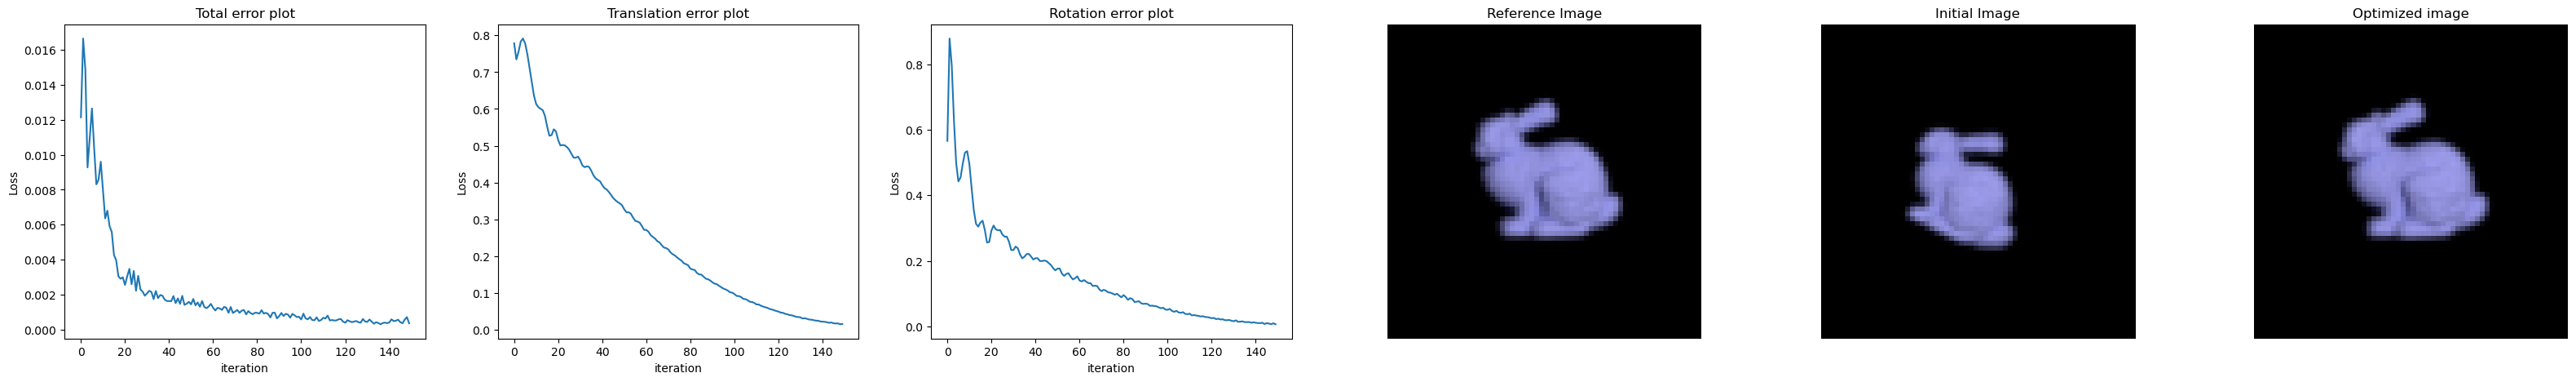

In [94]:
f = "q_v2_0"
record_p_1, record_r_1 = run_optimization(f, params,scene,opt,img_ref,iteration_count=its,spp=64)

In [95]:
vis_result(f,record_p_1,record_r_1,ref_R,ref_T,coef=0.05,reduce_scale=10)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0163668…

Plot saved to file ./camera_results/q_v2_0bunny.html.


## e2

In [96]:
scene, params, img_ref = init_scene()

In [97]:
opt = Q_Adam(lr=0.05, mode = 1)
# opt['q'] = w_to_q(SO3_to_so3(mi.Matrix3f(opt_init_state.matrix)))
opt['q'] = mi.Vector4f(dr.matrix_to_quat(mi.Matrix3f(opt_init_state.matrix)))
opt['Trans'] = opt_init_state.translation()

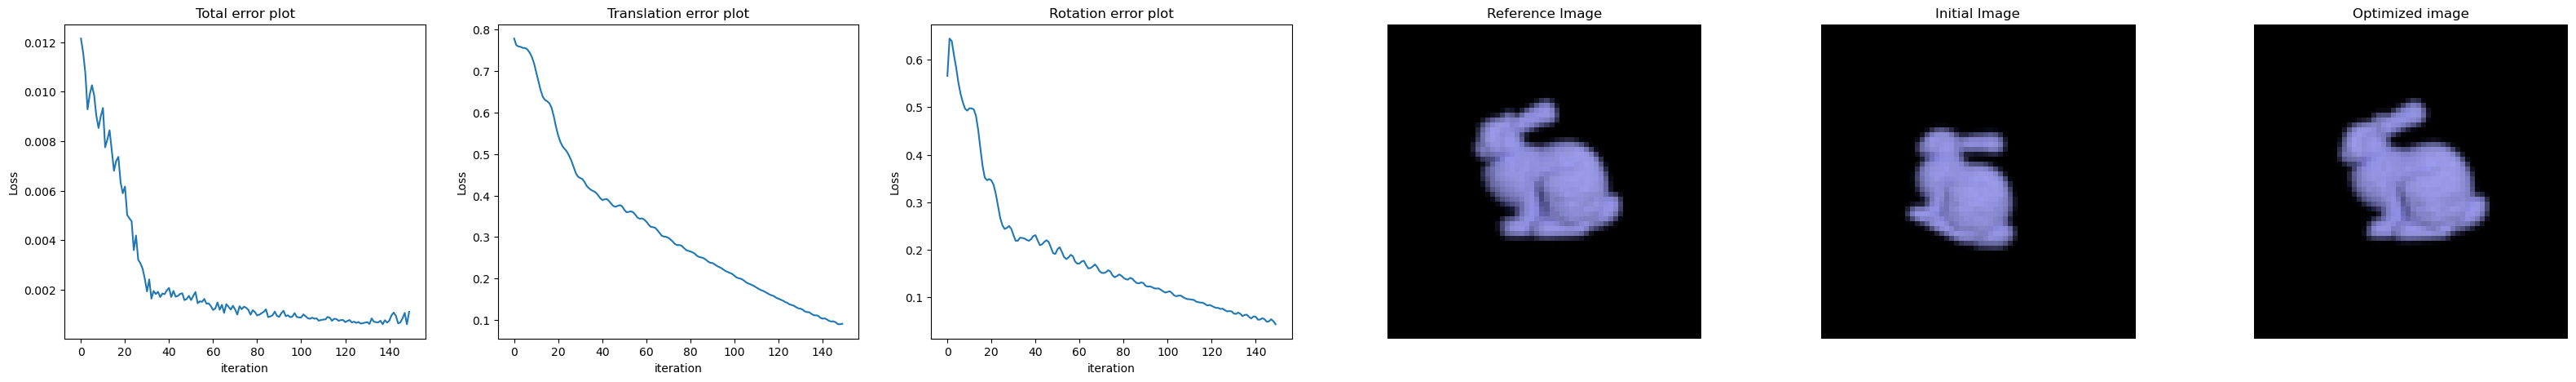

In [98]:
f = "q_v2_1"
record_p_1, record_r_1 = run_optimization(f, params,scene,opt,img_ref,iteration_count=its,spp=64)

In [99]:
vis_result(f,record_p_1,record_r_1,ref_R,ref_T,coef=0.05,reduce_scale=10)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0163668…

Plot saved to file ./camera_results/q_v2_1bunny.html.


## e3

In [100]:
scene, params, img_ref = init_scene()

In [101]:
opt = Q_Adam(lr=0.05, mode = 2)
# opt['q'] = w_to_q(SO3_to_so3(mi.Matrix3f(opt_init_state.matrix)))
opt['q'] = mi.Vector4f(dr.matrix_to_quat(mi.Matrix3f(opt_init_state.matrix)))
opt['Trans'] = opt_init_state.translation()

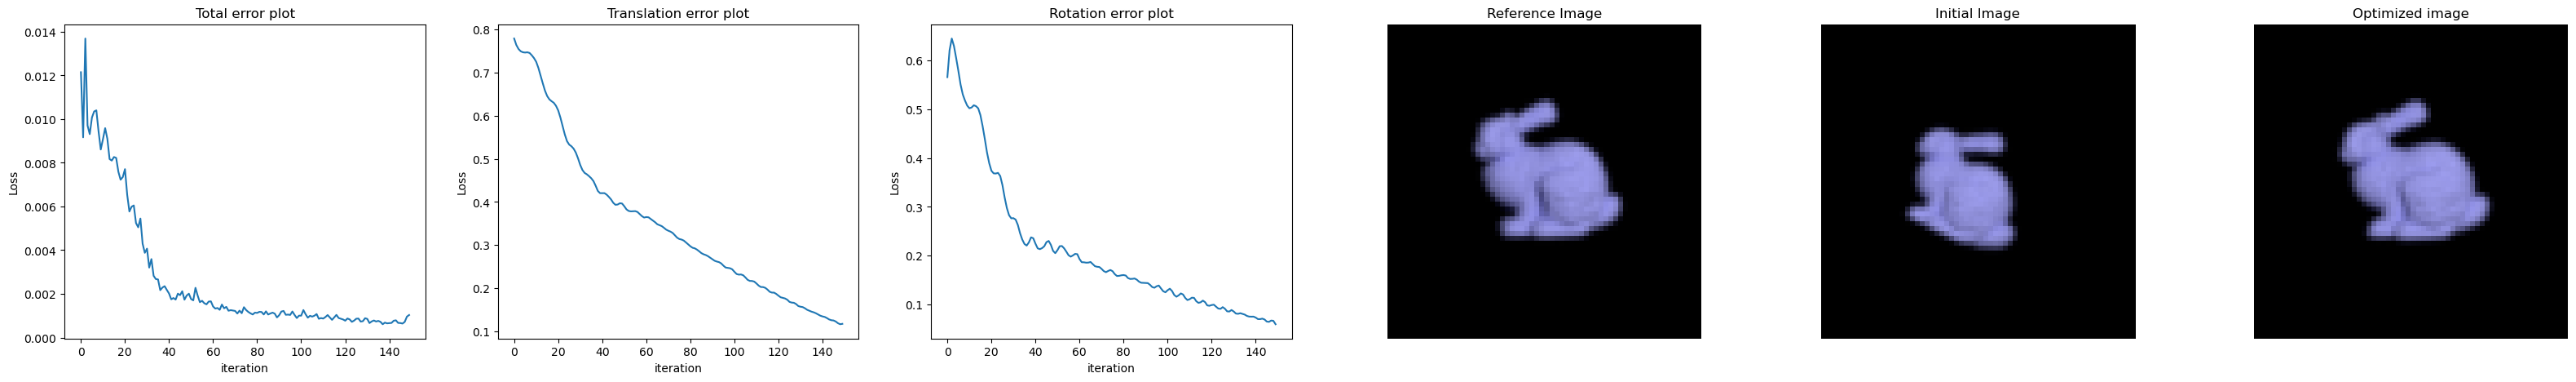

In [102]:
f = "q_v2_2"
record_p_1, record_r_1 = run_optimization(f, params,scene,opt,img_ref,iteration_count=its,spp=64)

In [103]:
vis_result(f,record_p_1,record_r_1,ref_R,ref_T,coef=0.05,reduce_scale=10)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0163668…

Plot saved to file ./camera_results/q_v2_2bunny.html.


# Plot comparison

## Adam

In [104]:
legends = ['se(3)','Euler Angle','so(3)','SO(3) Matrix','Unit Quaternion 1','Unit Quaternion 2']

In [106]:
folder = './camera_results/'
name = ['se','euler','vector','so','q_v1_','q_v2_']
loss = '_loss.npy'
hist = []
for i in range(6):
    hist.append(np.load(folder+name[i]+str(0)+loss))

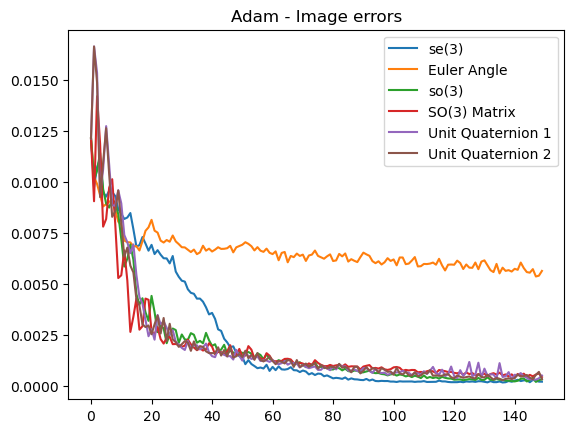

In [107]:
for i in range(6):
    plt.plot(hist[i])

plt.legend(legends)
plt.title('Adam - Image errors')
plt.savefig(folder+'Adam_image.png')

In [108]:
folder = './camera_results/'
name = ['se','euler','vector','so','q_v1_','q_v2_']
loss = '_rot_loss.npy'
hist = []
for i in range(6):
    hist.append(np.load(folder+name[i]+str(0)+loss))


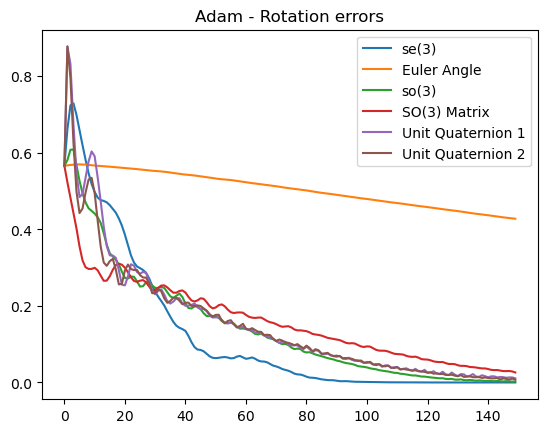

In [109]:
for i in range(6):
    plt.plot(hist[i])

plt.legend(legends)
plt.title('Adam - Rotation errors')
plt.savefig(folder+'Adam_rot.png')

In [110]:
folder = './camera_results/'
name = ['se','euler','vector','so','q_v1_','q_v2_']
loss = '_trans_loss.npy'
hist = []
for i in range(6):
    hist.append(np.load(folder+name[i]+str(0)+loss))

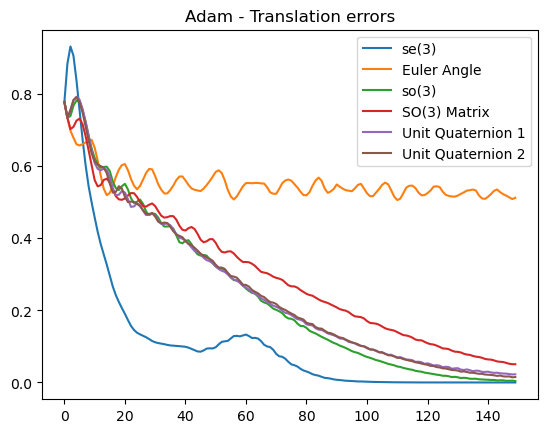

In [111]:
for i in range(6):
    plt.plot(hist[i])

plt.legend(legends)
plt.title('Adam - Translation errors')
plt.savefig(folder+'Adam_trans.png')

## Unifrom Adam

In [112]:
legends = ['se(3)','Euler Angle','so(3)','SO(3) Matrix','Unit Quaternion 1','Unit Quaternion 2']

In [113]:
folder = './camera_results/'
name = ['se','euler','vector','so','q_v1_','q_v2_']
loss = '_loss.npy'
hist = []
for i in range(6):
    hist.append(np.load(folder+name[i]+str(1)+loss))


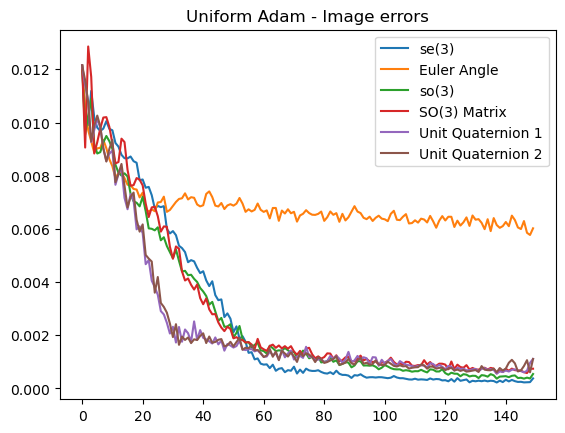

In [114]:
for i in range(6):
    plt.plot(hist[i])

plt.legend(legends)
plt.title('Uniform Adam - Image errors')
plt.savefig(folder+'Unifrom_Adam_image.png')

In [115]:
folder = './camera_results/'
name = ['se','euler','vector','so','q_v1_','q_v2_']
loss = '_rot_loss.npy'
hist = []
for i in range(6):
    hist.append(np.load(folder+name[i]+str(1)+loss))


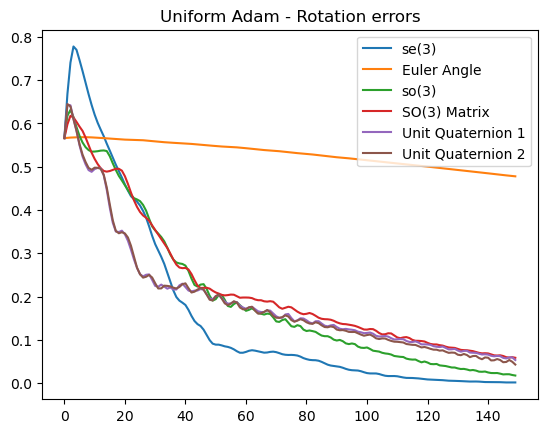

In [116]:
for i in range(6):
    plt.plot(hist[i])

plt.legend(legends)
plt.title('Uniform Adam - Rotation errors')
plt.savefig(folder+'Uniform_Adam_rot.png')

In [117]:
folder = './camera_results/'
name = ['se','euler','vector','so','q_v1_','q_v2_']
loss = '_trans_loss.npy'
hist = []
for i in range(6):
    hist.append(np.load(folder+name[i]+str(1)+loss))

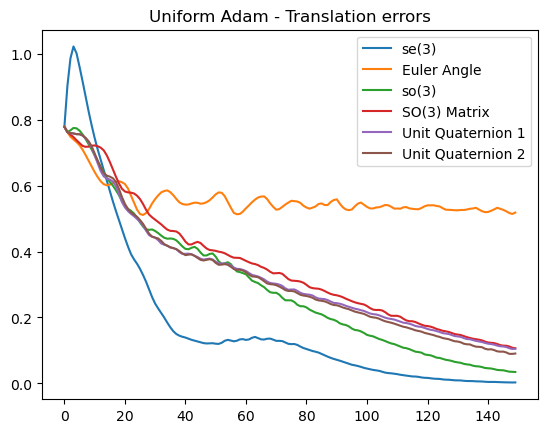

In [118]:
for i in range(6):
    plt.plot(hist[i])

plt.legend(legends)
plt.title('Uniform Adam - Translation errors')
plt.savefig(folder+'Uniform_Adam_trans.png')

## Vector Adam

In [119]:
legends = ['se(3)','Euler Angle','so(3)','SO(3) Matrix','Unit Quaternion 1','Unit Quaternion 2']

In [120]:
folder = './camera_results/'
name = ['se','euler','vector','so','q_v1_','q_v2_']
loss = '_loss.npy'
hist = []
for i in range(6):
    hist.append(np.load(folder+name[i]+str(2)+loss))


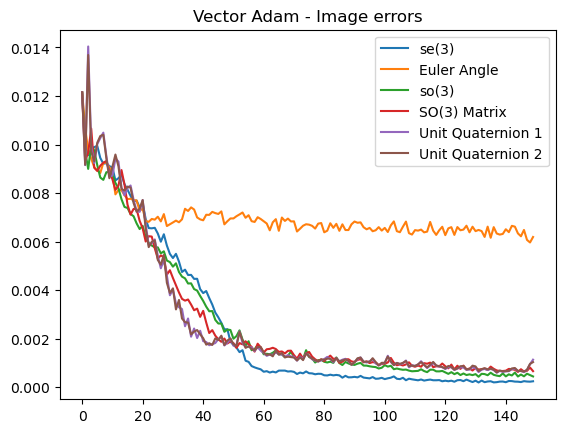

In [121]:
for i in range(6):
    plt.plot(hist[i])

plt.legend(legends)
plt.title('Vector Adam - Image errors')
plt.savefig(folder+'Vector_Adam_image.png')

In [122]:
folder = './camera_results/'
name = ['se','euler','vector','so','q_v1_','q_v2_']
loss = '_rot_loss.npy'
hist = []
for i in range(6):
    hist.append(np.load(folder+name[i]+str(2)+loss))


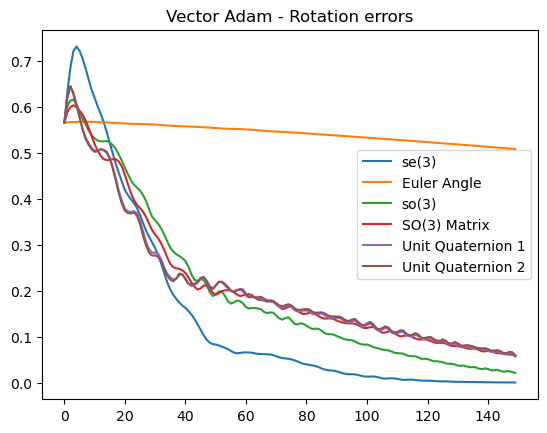

In [123]:
for i in range(6):
    plt.plot(hist[i])

plt.legend(legends)
plt.title('Vector Adam - Rotation errors')
plt.savefig(folder+'Vector_Adam_rot.png')

In [124]:
folder = './camera_results/'
name = ['se','euler','vector','so','q_v1_','q_v2_']
loss = '_trans_loss.npy'
hist = []
for i in range(6):
    hist.append(np.load(folder+name[i]+str(2)+loss))

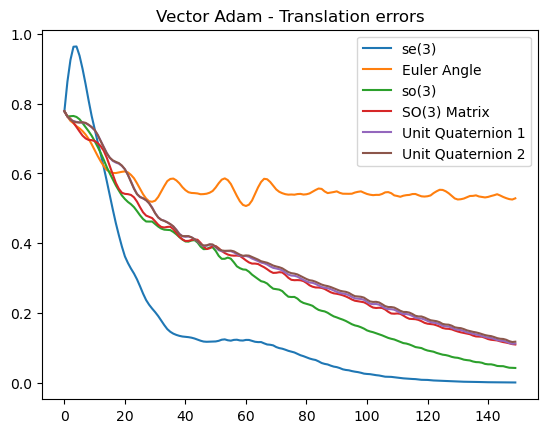

In [125]:
for i in range(6):
    plt.plot(hist[i])

plt.legend(legends)
plt.title('Vector Adam - Translation errors')
plt.savefig(folder+'Vector_Adam_trans.png')